In [4]:
import numpy as np

import pandas as pd

from zse.collections import *
from zse.utilities import *

from ase.io import read, write
from matplotlib import cm
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.cluster import KMeans

from collections import defaultdict

from sklearn.metrics import silhouette_samples, silhouette_score, completeness_score, homogeneity_score, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.preprocessing import StandardScaler

import itertools
from itertools import permutations

from sklearn.preprocessing import MinMaxScaler
import sys

from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator

In [5]:
def get_fw_data(file,code):
    
    # file is the file we want to read from
    # code is the IZA framework code you want data on
    
    file = open(file,'r')
    data = file.readlines()
    file.close()
    
    for i,line in enumerate(data):
        fields = line.split()
        if fields[0] == code:
            start = i
            break
    
    # go through fw chunk and get data
    
    t_sites = {}
    o_sites = {}
    for i,line in enumerate(data[start+1:]):
        line = line.rstrip(' \n')

        # get the t site rings
        
        if 'T' in line and ':' in line:
            fields = line.split(':')
            t_sites[fields[0]]=fields[1]                
        
        # get the o site rings
        
        if 'O' in line and ':' in line:
            fields = line.split(':')
            o_sites[fields[0]]=fields[1]        
        
        fields = line.split()
        if fields[0] == 'Framework':
            end = i+start-1
            break

    return(t_sites,o_sites)    

def numofrings(file,code):
    #might already be a function called counter so come up with very unique names otherwsie function overrides it -- isseue with kernel resets
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: number of each rings inside'''
    
    #call function to get data
    tsites, osites = get_fw_data(file,code)
    
    for t in tsites:
        #print('check 1')
        #resets dictionary each tsite
        tsite_dict = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
        #ways to make dictionary without knowing what it is 
        
        #make into vector not dictionary 
        
        #restarts j to 1 to check for ring size
        j = 1
        #go through all of the one tsite
        for i in range(0,len(tsites[t])-2,2):
            #print('check 2')
            #set yes to true
            print('i is',i)
            yes = True
            while yes:
                #print('check 3')
                #print(tsites[t][i])
                #print(int(tsites[t][i]) == j)
                #print(tsite_dict[j])
                #number of rings matches dictionary component
                if int(tsites[t][i]) == j:
                    print('check 4')
                    tsite_dict[j] = tsite_dict[j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    
                    j = j + 1
                    print('j is',j)
        print(t,tsite_dict)
        

def nringsvector(code,file):
    '''takes in the file and code name and returns how many of each ring type is present
    arguments: file: dataset
                code: which zeolite is being observed
    returns: vector of number of rings for each tsite'''
    
    #get site data
    tsites, osites = get_fw_data(file,code)
    
    #create empty vector
    A = np.zeros([len(tsites),21])
    
    #coutner for which row of the matrix you are in
    k=0 
    
    #go through each tsite
    for t in tsites:
        #initialize accumulator 
        j=1
        
        #make list of number of rings
        tsites_list = tsites[t].split('_')
        #go through the string for each t list
        for i in range(0,len(tsites_list)):
            #make the while loop true each for loop
            yes = True
            while yes:
                if int(tsites_list[i]) == j:
                    A[k][j] = A[k][j] + 1
                    #end while loop 
                    yes = False
                #increase j 
                else:
                    j = j + 1
        #increase row
        k = k +1 
    return A

def assemblematrix(file):
    fws = get_all_fws()
    fws = fws[1:]
    B = nringsvector('ABW',file)
    for code in fws:
        C = nringsvector(code,file)
        B = np.append(B, C, axis=0)
    return B

def kmeans_percent(file,ncluster):
    A = assemblematrix(file)
    clustering = KMeans(n_clusters = ncluster).fit(A)
    cluster = clustering.labels_

    sorted_clusters = defaultdict(list) #inside parentheses put the type of value ie list int

    fws = get_all_fws()
    #testing to see if Tsite make it a similar cluster
    dict_fws = {}
    count = 0
    for code in fws:
        dict_fws[code] = []
        tsites, osites = get_fw_data(file,code)
        for t in tsites:
            dict_fws[code].append(cluster[count])
            count = count + 1
    allsame = 0
    no1 = 0
    for k in dict_fws:
        if len(dict_fws[k]) > 1:
            no1 = no1 + 1
            avg = sum(dict_fws[k])/len(dict_fws[k])
            if avg == dict_fws[k][0]:
                if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                    allsame = allsame + 1
    per = allsame/no1
    return per, dict_fws 

def weight_avg(file):
    '''Takes in a files frameworks and makes a wieghted average for each framewokr
        Arguments: file - whichever defintion of ring used
        returns: an array of the values'''
    fws = get_all_fws()
    fws_weights = np.zeros([len(fws),21])
    count = 0
    for code in fws:
        #get tsite sata
        tsites, osites = get_fw_data(file,code)
        ts, tm, ti = get_tsites(code)
        #number of tsites
        n = len(tsites)
        #get the matrix of the tsite vectors
        rings = nringsvector(code,file)
        temp = np.zeros(len(rings[0]))
        #to move through the rings matrix
        ring_count = 0
        #calculate weights and add them rows of tsite values together
        for s,m,i in zip(ts,tm,ti):
            #calculate weight
            w = m/sum(tm)
            #make weighted framework
            temp = w*rings[ring_count] + temp
            ring_count = ring_count + 1
        fws_weights[count] = temp
        #increase row number
        count = count + 1
    return fws_weights

def compare4(A,B,nclusters,vbool=False):
    #get data 
    Azlist, Aist = Kmeansresults(A,nclusters,False)
    Bzlist, Bist = Kmeansresults(B,nclusters,False)

    print(Aist)
    print(Bist)
    #make default dictionaries to reorganzie the zlist
    Alist = defaultdict(list)
    Blist = defaultdict(list)
    
    #sort the dictionaries numerically
    m = 0
    for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
    m = 0
    for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
        Blist[m] = Bzlist[k]
        m = m + 1   
    # combinations
    unique_combinations = []
 
    # Getting all permutations of list_1
    # with length of list_2
    permut = itertools.permutations(Alist, len(Blist))
    # zip() is called to pair each permutation
    # and shorter list element into combination
    for comb in permut:
        zipped = zip(comb, Blist)
        unique_combinations.append(list(zipped))
       
    
    #create an array to store values
    array_values = np.zeros([nclusters,nclusters])
    #print('')
    #loop over unique combinations 
    for n in range(nclusters):
        for i in range(nclusters):
            #index into the first part of the ordered pair
            a = unique_combinations[n][i][0]
            #index into the second part of the ordered pair
            b = unique_combinations[n][i][1]
            #find what is in common with the two lists 
            c = list(set(Alist[a]).intersection(Blist[b]))
            #add the value to the array
            array_values[n,i] = len(c)
    #print(array_values)
    #print('')
    
    #store results 
    temp = []
    #print results 
    for t in range(nclusters):
        print(sum(array_values[t])/253)
        temp.append(sum(array_values[t])/253)
        
    return temp

def isNaN(num):
    return num!= num

def properties(A,values,nclusters,vbool=False):
    '''Arguments:
    
        A: the assembled matrix
        nclusters: number of clusters
        values: data framework to be texted'''
    #get all the frameworks
    fws = get_all_fws()
    #get the clusters
    Azlist, Aist = Kmeansresults(A,nclusters,vbool)
    #create a values dictionary to store the frameworks IZa values
    value_dict = defaultdict(list)
    #go through all the clusters
    for k in Azlist:
        #go through all the frameworks in each cluster
        for i in range(len(Azlist[k])):
            #find the index for the framework
            idx = fws.index(Azlist[k][i])
            if isNaN(values[idx]) != True:
                #add the framework's values to the dictionary
                value_dict[k].append(int(values[idx]))
    
    
    #list of the averages
    avg = []
    #list of the standard deviations
    stdev = []
    for k in value_dict:
        x = sum(value_dict[k])/len(value_dict[k])
        avg.append(x)
        y = np.std(value_dict[k])
        stdev.append(y)
                   
    return avg, stdev

def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    llist.sort()
    
    return zlist, llist


In [3]:
#cluster with 243 frameworks and then compare with different ring methods 
A = assemblematrix('../Data/crum_rings.txt')
clustering_crum = KMeans(n_clusters = 243).fit(A)
cluster_crum = clustering_crum.labels_
print(len(cluster_crum))

1460


In [19]:
sorted_clusters_crum = defaultdict(list) #inside parentheses put the type of value ie list int
#for x in range(max(cluster_goetzke)):
#    sorted_clusters_goetzke[x] = '' 

fws = get_all_fws()


start = 0
for code in fws:
    tsites, osites = get_fw_data('../Data/crum_rings.txt',code)
    for t in tsites:
        name = code + t
        sorted_clusters_crum[cluster_crum[start]].append(name)
        start = start + 1
cdata = []
for keys in sorted_clusters_crum:
    cdata.append(sorted_clusters_crum[keys])

#testing to see if Tsite make it a similar cluster
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/crum_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_crum[count])
        count = count + 1
allsame = 0
for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                allsame = allsame + 1
print(allsame/len(dict_fws))

0.05533596837944664


In [21]:
#check to see if they r balanced 
for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            allsame = allsame + 1
print(allsame/len(dict_fws))

0.17391304347826086


In [30]:
A = assemblematrix('../Data/goetzke_rings.txt')
clustering_goetzke = KMeans(n_clusters = 243).fit(A)
cluster_goetzke = clustering_goetzke.labels_

sorted_clusters_goetzke = defaultdict(list) #inside parentheses put the type of value ie list int
#for x in range(max(cluster_goetzke)):
#    sorted_clusters_goetzke[x] = '' 

fws = get_all_fws()


start = 0
for code in fws:
    tsites, osites = get_fw_data('../Data/goetzke_rings.txt',code)
    for t in tsites:
        name = code + t
        sorted_clusters_goetzke[cluster_goetzke[start]].append(name)
        start = start + 1
cdata = []
for keys in sorted_clusters_goetzke:
    cdata.append(sorted_clusters_goetzke[keys])

#testing to see if Tsite make it a similar cluster
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/goetzke_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_goetzke[count])
        count = count + 1
allsame = 0
for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            print(dict_fws[k],dict_fws[k][len(dict_fws[k])-1])
            if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                allsame = allsame + 1
print(allsame/len(dict_fws))

[177, 177, 177] 177
[155, 155, 155] 155
[155, 155] 155
[12, 12] 12
[83, 83] 83
[88, 88, 88] 88
[177, 177] 177
[15, 15, 15, 15] 15
[86, 86] 86
[185, 185, 185, 185] 185
[123, 123] 123
[22, 22] 22
[187, 187, 187] 187
[12, 12] 12
[214, 214] 214
0.05928853754940711


In [27]:
A = assemblematrix('../Data/vertex_rings.txt')
clustering_vertex = KMeans(n_clusters = 243).fit(A)
cluster_vertex = clustering_vertex.labels_

sorted_clusters_vertex = defaultdict(list) #inside parentheses put the type of value ie list int
#for x in range(max(cluster_goetzke)):
#    sorted_clusters_goetzke[x] = '' 

fws = get_all_fws()


start = 0
for code in fws:
    tsites, osites = get_fw_data('../Data/vertex_rings.txt',code)
    for t in tsites:
        name = code + t
        sorted_clusters_vertex[cluster_vertex[start]].append(name)
        start = start + 1
cdata = []
for keys in sorted_clusters_vertex:
    cdata.append(sorted_clusters_vertex[keys])

#testing to see if Tsite make it a similar cluster
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/vertex_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_vertex[count])
        count = count + 1
allsame = 0
for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                allsame = allsame + 1
print(allsame/len(dict_fws))

0.06719367588932806


In [32]:
A = assemblematrix('../Data/sastre_rings.txt')
clustering_sastre = KMeans(n_clusters = 243).fit(A)
cluster_sastre = clustering_sastre.labels_

sorted_clusters_sastre = defaultdict(list) #inside parentheses put the type of value ie list int
#for x in range(max(cluster_goetzke)):
#    sorted_clusters_goetzke[x] = '' 

fws = get_all_fws()


start = 0
for code in fws:
    tsites, osites = get_fw_data('../Data/sastre_rings.txt',code)
    for t in tsites:
        name = code + t
        sorted_clusters_sastre[cluster_sastre[start]].append(name)
        start = start + 1
cdata = []
for keys in sorted_clusters_sastre:
    cdata.append(sorted_clusters_sastre[keys])

print(cdata)
#testing to see if Tsite make it a similar cluster
dict_fws = {}
count = 0
for code in fws:
    dict_fws[code] = []
    tsites, osites = get_fw_data('../Data/sastre_rings.txt',code)
    for t in tsites:
        dict_fws[code].append(cluster_sastre[count])
        count = count + 1
print(dict_fws)
allsame = 0
for k in dict_fws:
    if len(dict_fws[k]) > 1:
        avg = sum(dict_fws[k])/len(dict_fws[k])
        if avg == dict_fws[k][0]:
            if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                allsame = allsame + 1
print(allsame/len(dict_fws))

[]
{'ABW': [78], 'ACO': [73], 'AEI': [31, 31, 31], 'AEL': [80, 80, 118], 'AEN': [133, 182, 21], 'AET': [80, 80, 80, 118, 152], 'AFG': [67, 67, 67], 'AFI': [80], 'AFN': [47, 70, 47, 127], 'AFO': [80, 21, 80, 118], 'AFR': [192, 231, 42, 42], 'AFS': [127, 231, 11], 'AFT': [31, 31, 31], 'AFV': [68, 31, 160], 'AFX': [31, 31], 'AFY': [240, 11], 'AHT': [21, 152], 'ANA': [242], 'APC': [73, 78], 'APD': [71, 182], 'AST': [20, 109], 'ASV': [63, 17], 'ATN': [162], 'ATO': [234], 'ATS': [42, 42, 42], 'ATT': [31, 172], 'ATV': [80, 118], 'AVE': [68, 162, 162, 68], 'AVL': [31, 68, 31, 160], 'AWO': [33, 172, 107], 'AWW': [162, 20], 'BCT': [109], 'BEC': [113, 3, 10], 'BIK': [176, 93], 'BOF': [29, 121, 206], 'BOG': [193, 116, 187, 25, 117, 29], 'BOZ': [35, 88, 35, 35, 35, 35, 35, 51], 'BPH': [127, 231, 11], 'BRE': [85, 85, 89, 139], 'BSV': [1], 'CAN': [67], 'CAS': [176, 93, 129], 'CDO': [200, 60, 23, 200], 'CFI': [6, 99, 99, 101, 99], 'CGF': [210, 165, 165, 165, 77], 'CGS': [47, 107, 107, 107], 'CHA': [31

In [3]:
def kmeans_percent(file,ncluster):
    A = assemblematrix(file)
    clustering = KMeans(n_clusters = ncluster).fit(A)
    cluster = clustering.labels_

    sorted_clusters = defaultdict(list) #inside parentheses put the type of value ie list int

    fws = get_all_fws()
    #testing to see if Tsite make it a similar cluster
    dict_fws = {}
    count = 0
    for code in fws:
        dict_fws[code] = []
        tsites, osites = get_fw_data(file,code)
        for t in tsites:
            dict_fws[code].append(cluster[count])
            count = count + 1
    allsame = 0
    no1 = 0
    for k in dict_fws:
        if len(dict_fws[k]) > 1:
            no1 = no1 + 1
            avg = sum(dict_fws[k])/len(dict_fws[k])
            if avg == dict_fws[k][0]:
                if dict_fws[k][0] == dict_fws[k][len(dict_fws[k])-1]:
                    allsame = allsame + 1
    per = allsame/no1
    return per, dict_fws 

In [8]:
fws = get_all_fws()
n = len(fws)
print(n)

253


In [9]:
goetzke_list = []
for i in range(10):
    per, l = kmeans_percent('../Data/goetzke_rings.txt',n)
    goetzke_list.append(per)



In [13]:
print(sum(goetzke_list)/10)

0.05757575757575758


In [10]:
sastre_list = []
for i in range(10):
    per, l = kmeans_percent('../Data/sastre_rings.txt',n)
    sastre_list.append(per)
print(sum(sastre_list)/10)

0.07835497835497837


In [12]:
vertex_list = []
for i in range(10):
    per, l = kmeans_percent('../Data/vertex_rings.txt',n)
    vertex_list.append(per)
print(sum(vertex_list)/10)

0.07359307359307361


In [11]:
crum_list = []
for i in range(10):
    per, l = kmeans_percent('../Data/crum_rings.txt',n)
    crum_list.append(per)
print(sum(crum_list)/10)

0.06493506493506493


In [43]:
#working on elminating only 1 from data set 

iza_values =pd.read_csv('../data/iza_data.csv')
fws = iza_values['Framework'].values
rings = iza_values['Rings'].values
ntsite = iza_values['Number of T Sites'].values

count  = 0
num1 = 0 
num1_list = []
for i in ntsite:
    if i == 1: 
        num1 = num1 + 1
        num1_list.append(fws[count])
    count = count + 1
print(num1)
print(num1_list)

22
['ABW', 'ACO', 'AFI', 'ANA', 'ATN', 'ATO', 'BCT', 'BSV', 'CAN', 'CHA', 'DFT', 'FAU', 'GIS', 'GME', 'KFI', 'LTA', 'MER', 'MON', 'NPO', 'RHO', 'RWY', 'SOD']


In [50]:
cper, cdata = kmeans_percent('../Data/crum_rings.txt',243)

c_list = []
for keys in num1_list:
    if len(cdata[keys]) == 1:
        c_list.append(keys)



In [51]:
print(c_list)
print(len(c_list))

['ABW', 'ACO', 'AFI', 'ANA', 'ATN', 'ATO', 'BCT', 'BSV', 'CAN', 'CHA', 'DFT', 'FAU', 'GIS', 'GME', 'KFI', 'LTA', 'MER', 'MON', 'NPO', 'RHO', 'RWY', 'SOD']
22


In [52]:
gper, gdata = kmeans_percent('../Data/goetzke_rings.txt',243)

g_list = []
for keys in num1_list:
    print(gdata[keys])
    if len(gdata[keys]) == 1:
        g_list.append(keys)


[161]
[232]
[57]
[121]
[49]
[204]
[174]
[1]
[44]
[71]
[198]
[212]
[161]
[101]
[99]
[59]
[61]
[168]
[134]
[17]
[103]
[3]


In [53]:
print(len(g_list))

22


In [ ]:
sper, sdata = kmeans_percent('../Data/sastre_rings.txt',243)

s_list = []
for keys in num1_list:
    print(sdata[keys])
    if len(sdata[keys]) == 1:
        s_list.append(keys)
print(len(s_list))

In [54]:
vper, vdata = kmeans_percent('../Data/vertex_rings.txt',243)

v_list = []
for keys in num1_list:
    print(vdata[keys])
    if len(vdata[keys]) == 1:
        v_list.append(keys)
print(len(v_list))

[54]
[185]
[3]
[22]
[123]
[56]
[73]
[2]
[5]
[6]
[35]
[81]
[37]
[6]
[6]
[32]
[37]
[23]
[196]
[6]
[162]
[5]
22


In [55]:
vdata['AEL']

[3, 3, 164]

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

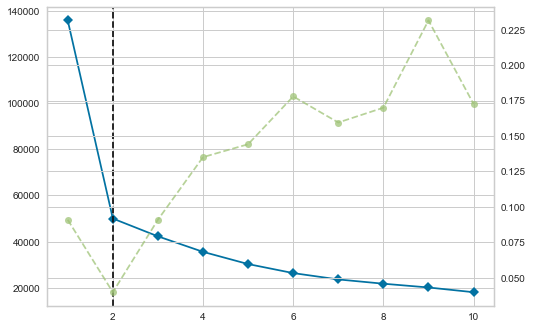

In [7]:
A = assemblematrix('../Data/sastre_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(A)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/elbow.pdf")        # Finalize and render the figure

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2))

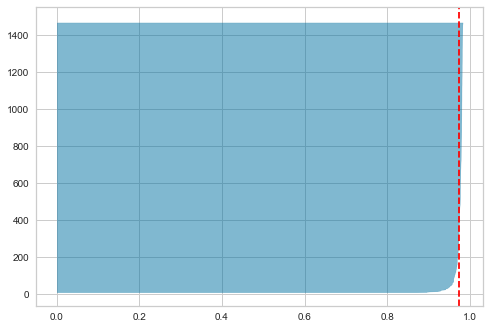

In [61]:
model = KMeans(2)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(A)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure


SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=3))

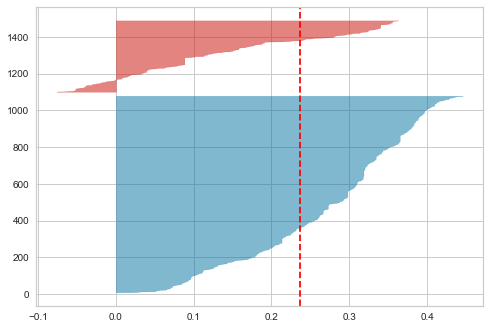

In [62]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(A)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure


SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4))

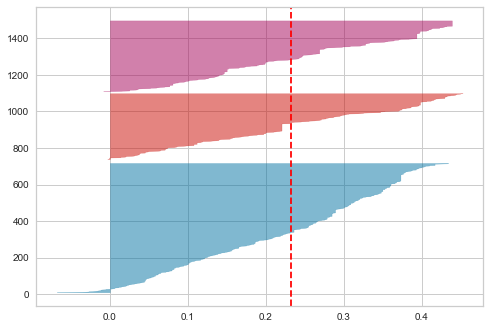

In [63]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(A)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure


SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=100))

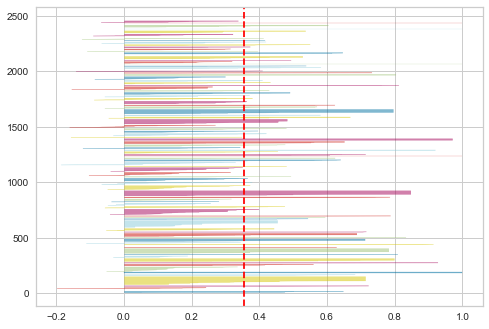

In [65]:
model = KMeans(100)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(A)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure


SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=40))

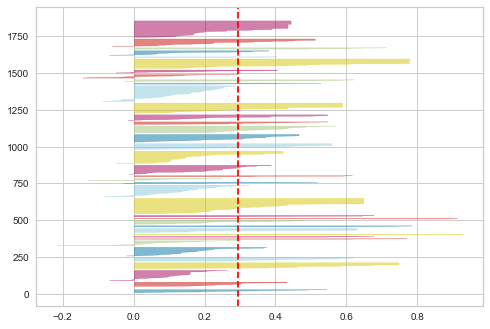

In [66]:
model = KMeans(40)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(A)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

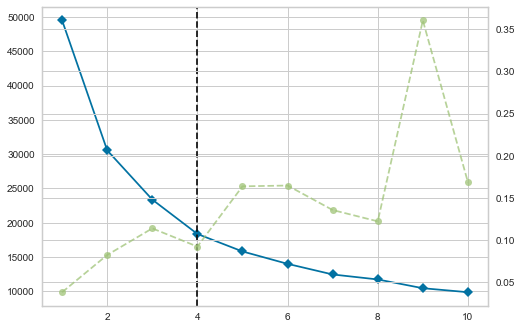

In [8]:
B = assemblematrix('../Data/vertex_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(B)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/elbow.pdf")        # Finalize and render the figure

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2))

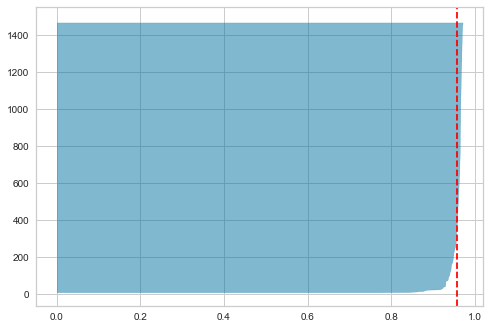

In [71]:
model = KMeans(2)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(B)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4))

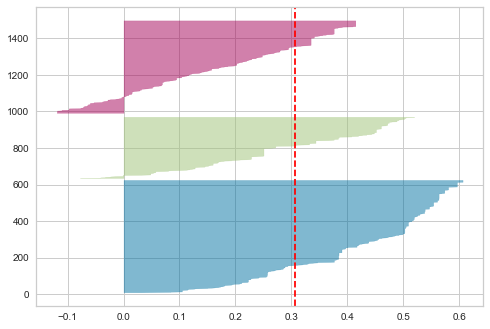

In [72]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(B)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

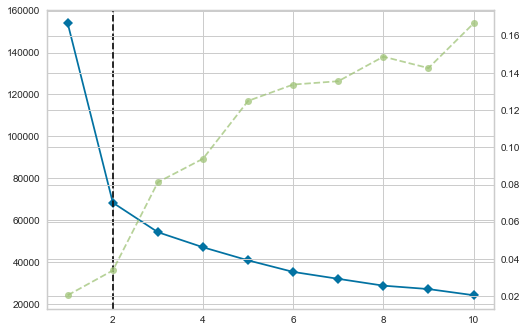

In [9]:
C = assemblematrix('../Data/crum_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(C)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/elbow.pdf")        # Finalize and render the figure

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2))

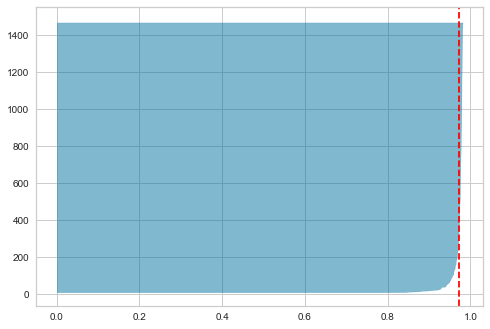

In [74]:
model = KMeans(2)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(C)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

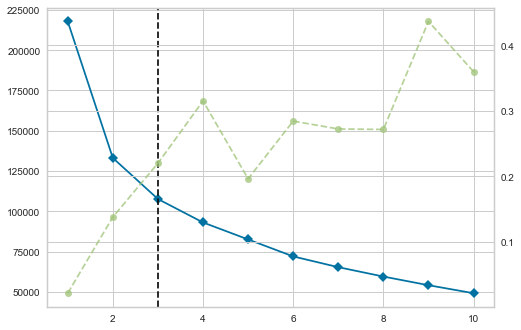

In [10]:
D = assemblematrix('../Data/goetzke_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(D)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/elbow.pdf")        # Finalize and render the figure

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=3))

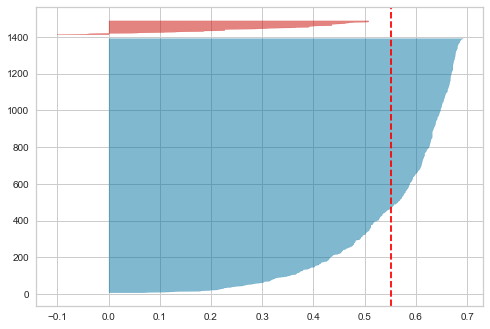

In [77]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(D)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2))

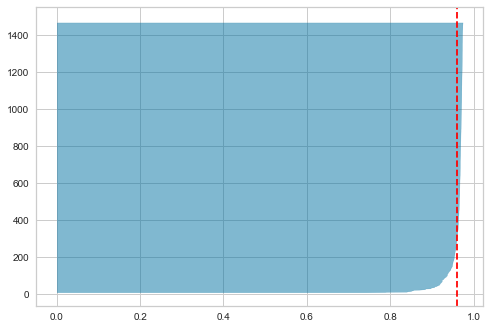

In [78]:
model = KMeans(2)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(D)        # Fit the data to the visualizer
# visualizer.show(outpath="Figures/Silhouett_coefficient.pdf")        # Finalize and render the figure

In [82]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=1,min_samples=5)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(D) 

AttributeError: 'DBSCAN' object has no attribute 'n_clusters'

In [19]:
code = 'SYT'
z = framework(code)
ts, tm, ti = get_tsites(code)
print(ts)
print(tm)
print(ti)
fws = get_all_fws()
print(len(fws))

['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
[32, 32, 16, 16, 16, 16]
[0, 32, 64, 80, 96, 112]
253


In [3]:
def weight_avg(file):
    '''Takes in a files frameworks and makes a wieghted average for each framewokr
        Arguments: file - whichever defintion of ring used
        returns: an array of the values'''
    fws = get_all_fws()
    fws_weights = np.zeros([len(fws),21])
    count = 0
    for code in fws:
        #get tsite sata
        tsites, osites = get_fw_data(file,code)
        ts, tm, ti = get_tsites(code)
        #number of tsites
        n = len(tsites)
        #get the matrix of the tsite vectors
        rings = nringsvector(code,file)
        temp = np.zeros(len(rings[0]))
        #to move through the rings matrix
        ring_count = 0
        #calculate weights and add them rows of tsite values together
        for s,m,i in zip(ts,tm,ti):
            #calculate weight
            w = m/sum(tm)
            #make weighted framework
            temp = w*rings[ring_count] + temp
            ring_count = ring_count + 1
        fws_weights[count] = temp
        #increase row number
        count = count + 1
    return fws_weights

In [21]:
x = weight_avg('../Data/goetzke_rings.txt')
print(x)

0
ABW
1
ACO
2
AEI
3
AEL
4
AEN
5
AET
6
AFG
7
AFI
8
AFN
9
AFO
10
AFR
11
AFS
12
AFT
13
AFV
14
AFX
15
AFY
16
AHT
17
ANA
18
APC
19
APD
20
AST
21
ASV
22
ATN
23
ATO
24
ATS
25
ATT
26
ATV
27
AVE
28
AVL
29
AWO
30
AWW
31
BCT
32
BEC
33
BIK
34
BOF
35
BOG
36
BOZ
37
BPH
38
BRE
39
BSV
40
CAN
41
CAS
42
CDO
43
CFI
44
CGF
45
CGS
46
CHA
47
CHI
48
CLO
49
CON
50
CSV
51
CZP
52
DAC
53
DDR
54
DFO
55
DFT
56
DOH
57
DON
58
EAB
59
EDI
60
EEI
61
EMT
62
EON
63
EPI
64
ERI
65
ESV
66
ETR
67
EUO
68
EWS
69
EZT
70
FAR
71
FAU
72
FER
73
FRA
74
GIS
75
GIU
76
GME
77
GON
78
GOO
79
HEU
80
IFO
81
IFR
82
IFT
83
IFU
84
IFW
85
IFY
86
IHW
87
IMF
88
IRN
89
IRR
90
IRY
91
ISV
92
ITE
93
ITG
94
ITH
95
ITR
96
ITT
97
ITV
98
ITW
99
IWR
100
IWS
101
IWV
102
IWW
103
JBW
104
JNT
105
JOZ
106
JRY
107
JSN
108
JSR
109
JST
110
JSW
111
KFI
112
LAU
113
LEV
114
LIO
115
LIT
116
LOS
117
LOV
118
LTA
119
LTF
120
LTJ
121
LTL
122
LTN
123
MAR
124
MAZ
125
MEI
126
MEL
127
MEP
128
MER
129
MFI
130
MFS
131
MON
132
MOR
133
MOZ
134
MRT
135
MSE
136
MSO
137
MTF
138
MT

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.00000000e+00 0.00000000e+00 3.00000000e+00 0.00000000e+00
  4.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.00000000e+00 0.00000000e+00 3.00000000e+00 0.00000000e+00
  6.00000000e+00 0.00000000e+00 1.50000000e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  6.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

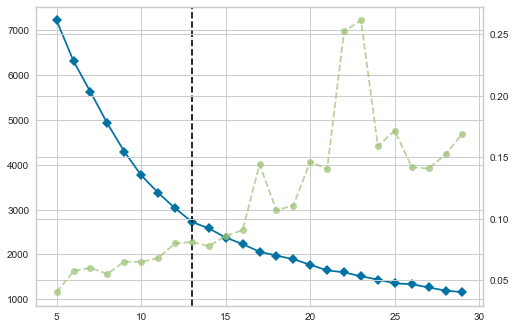

In [27]:
C = weight_avg('../Data/crum_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,30))
visualizer.fit(C) 

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

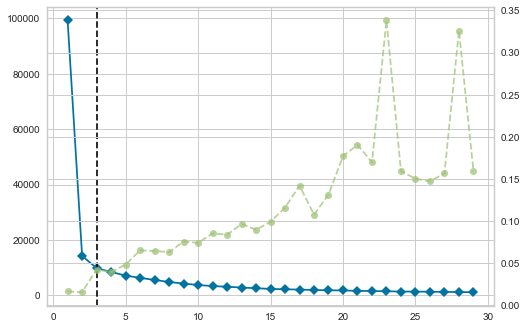

In [28]:
C = weight_avg('../Data/crum_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,30))
visualizer.fit(C) 

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

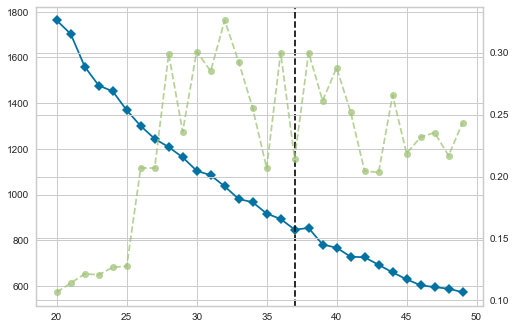

In [29]:
C = weight_avg('../Data/crum_rings.txt')

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(20,50))
visualizer.fit(C) 

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=13))

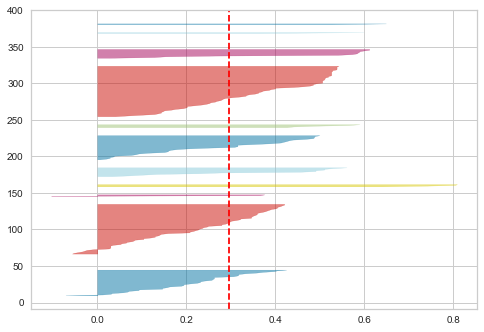

In [30]:
model = KMeans(13)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(C)

0.31097785447898924
0.9668115941594496
0.7080031594467328
0.1910550311780353
0.2398883846081378
0.2929409927841931
0.2992337615148171
0.25562243384243466
0.27435468818902853
0.28801917761005547
0.27789713930254617
0.3003497177390307
0.25520195778712684
0.3099679735540024
0.2574503864586248
0.26634913112609065
0.3035900020096387
0.2526614548578133
0.2759903831721838
0.3046856931924212
0.29334951415573296
0.26539648537603805
0.2864807561527835
0.28053824749954903
0.29578648788114986
0.2831650358712346
0.2896658587786986
0.2811684973764374
0.2949046441175625
0.2984203708940251
0.30339699994832064
0.2978569101234327
0.29938380561774863
0.29523962333379894
0.30899548562759405
0.29696770715233145
0.30444213953433497
0.2967692436204245
0.2955433285261132
0.30838829597068645
0.30528553718895574
0.31344066295702516
0.3155985176637722
0.3194543563259177
0.3004485674046034
0.30838615012846277
0.30353157734431124
0.31898971105091156
0.29821813307049716
0.31225594448142946
0.31155105667575805
0.323

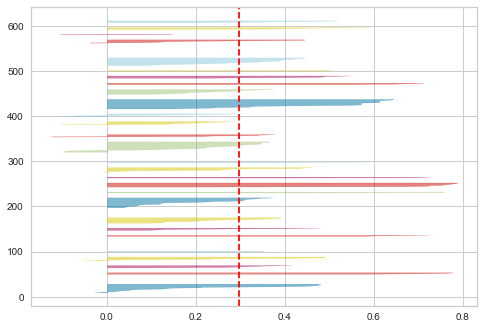

In [45]:
model = KMeans(36)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(C)

clustering = KMeans(36).fit(C)
cluster = clustering.labels_
print(silhouette_score(C,cluster))

for i in range(2,60):
    clustering = KMeans(i).fit(C)
    cluster = clustering.labels_
    print(silhouette_score(C,cluster))

NameError: name 'cluster' is not defined

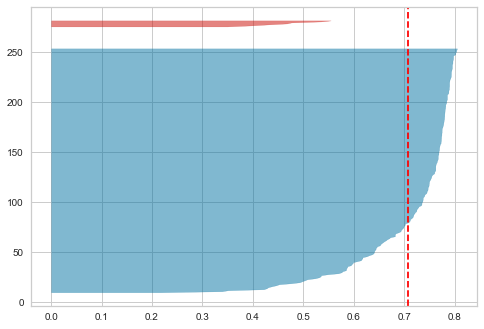

In [37]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(C)

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=4))

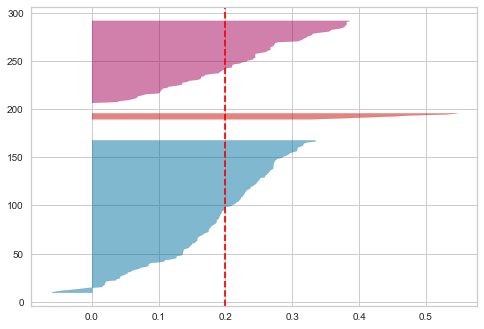

In [34]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(C)

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2))

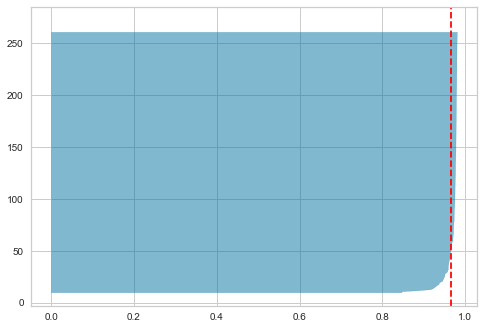

In [35]:
model = KMeans(2)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(C)

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

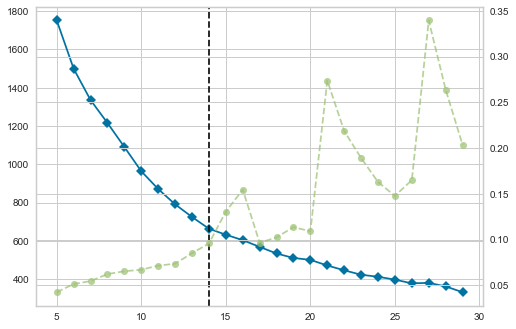

In [36]:
B = weight_avg('../Data/vertex_rings.txt')


# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,30))
visualizer.fit(B) 

print(silhouette_score(B,cluster))

In [4]:
A = weight_avg('../Data/sastre_rings.txt')
B = weight_avg('../Data/vertex_rings.txt')
C = weight_avg('../Data/crum_rings.txt')
D = weight_avg('../Data/goetzke_rings.txt')

In [7]:
x = np.linspace(2,70,69)
print(x)
sastre_hist = np.zeros(len(x))
vertex_hist = np.zeros(len(x))
crum_hist = np.zeros(len(x))
goetzke_hist = np.zeros(len(x))

for i in range(2,70):
    clustering = KMeans(i).fit(B)
    cluster = clustering.labels_
    sastre_hist[i-2] = silhouette_score(B,cluster)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55.
 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]


In [8]:

for i in range(2,70):
    clustering = KMeans(i).fit(A)
    cluster = clustering.labels_
    vertex_hist[i-2]  = (silhouette_score(A,cluster))

In [9]:

for i in range(2,70):
    clustering = KMeans(i).fit(D)
    cluster = clustering.labels_
    goetzke_hist[i-2] = (silhouette_score(D,cluster))

In [10]:
for i in range(2,70):
    clustering = KMeans(i).fit(C)
    cluster = clustering.labels_
    crum_hist[i-2] = (silhouette_score(C,cluster))

[0.96681159 0.70800316 0.20497724 0.2314608  0.26217568 0.27975256
 0.26980703 0.28291083 0.27866054 0.29405157 0.28923404 0.26803358
 0.28472302 0.31042677 0.31153365 0.27065531 0.28355339 0.30502267
 0.26184772 0.28170944 0.29433306 0.27660599 0.28305485 0.2905017
 0.28731995 0.2573511  0.30623981 0.28911388 0.28393947 0.28812715
 0.27855985 0.29221833 0.28291526 0.30204017 0.30189672 0.30223345
 0.30487186 0.30808233 0.29081031 0.29731243 0.31180007 0.30193979
 0.31927421 0.29996288 0.30424727 0.30602329 0.33034099 0.31700786
 0.31385652 0.31120408 0.32288964 0.32633162 0.31698731 0.34019193
 0.31882593 0.34280783 0.33291601 0.33731986 0.310561   0.32003422
 0.32923707 0.33099267 0.33881649 0.32612611 0.32373612 0.33087777
 0.32769512 0.34549423 0.        ]


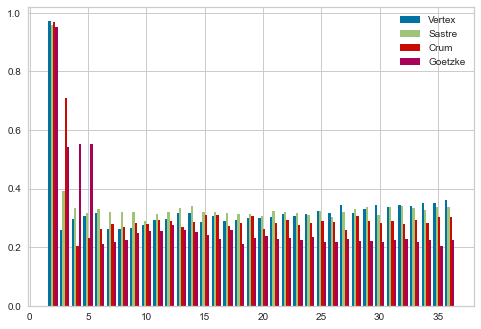

In [11]:
print(crum_hist)
plt.bar(x[0:35]-.3,vertex_hist[0:35],width = .2,label = 'Vertex')
plt.bar(x[0:35]-.1,sastre_hist[0:35],width = .2,label = 'Sastre')
plt.bar(x[0:35]+.1,crum_hist[0:35],width = .2,label = 'Crum')
plt.bar(x[0:35]+.3,goetzke_hist[0:35],width = .2,label = 'Goetzke')
plt.legend()

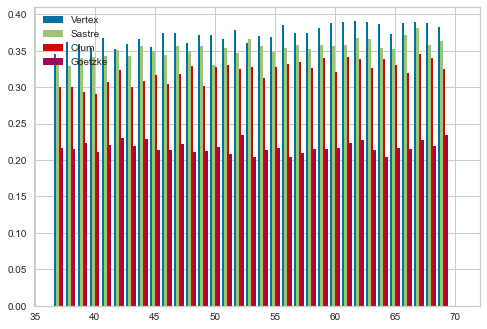

In [125]:
plt.bar(x[35:70]-.3,vertex_hist[35:70],width = .2,label = 'Vertex')
plt.bar(x[35:70]-.1,sastre_hist[35:70],width = .2,label = 'Sastre')
plt.bar(x[35:70]+.1,crum_hist[35:70],width = .2, label = 'Crum')
plt.bar(x[35:70]+.3,goetzke_hist[35:70],width = .2, label = 'Goetzke')
plt.legend()

In [105]:
#vertex and sastre are better at sorting them from the silohueette scores
#crum is a little behind them and goetzke is the worse

iza_values =pd.read_csv('../data/iza_data.csv')
fws = iza_values['Framework'].values
density = iza_values['Density (T sites/ 1000 Å^3)'].values
volume = iza_values['Volume (Å^3)'].values

print(type(density[174]))
#print(float(nan))

<class 'numpy.float64'>


In [5]:
def isNaN(num):
    return num!= num
n = 0
den_vol = np.zeros([253,2])
for i in range(len(density)):
    if isNaN(density[i]) != True and isNaN(volume[i]) != True:
        den_vol[n][0] = density[i]
        den_vol[n][1] = volume[i]
        n = n + 1
print(density[174] == float('nan'))
print(density[173] == density[173])

print(den_vol)
#den_vol = den[0:70]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(den_vol[0:247]) 

clustering = KMeans().fit(den_vol[0:247])
cluster = clustering.labels_

NameError: name 'density' is not defined

In [14]:
for i in range(2,70):
    clustering = KMeans(i).fit(den_vol[0:247])
    cluster = clustering.labels_
    print(i,silhouette_score(den_vol[0:247],cluster))

2 0.9223124375388118
3 0.9058831447737775
4 0.6959556820368278
5 0.6359928222431774
6 0.6110725476342183
7 0.6098647612230516
8 0.6101445910037936
9 0.5898223703315041
10 0.5914141871794157
11 0.5933497953042105
12 0.5681858354595233
13 0.5669368294238997
14 0.535146021518255
15 0.5816508997563962
16 0.5556459501170887
17 0.5866474433172715
18 0.5926152218297533
19 0.5930129738232085
20 0.596358190272928
21 0.5938327646823385
22 0.5807875060384698
23 0.5487003671998051
24 0.5508933399342071
25 0.5518050407102921
26 0.55325188368821
27 0.546594455766774
28 0.5618004676801546
29 0.5782353665743306
30 0.5657915648431917
31 0.5571914522025996
32 0.5717958935463217
33 0.5547551473049892
34 0.5715537828179492
35 0.5779751571941361
36 0.5692166606766761
37 0.571998884986245
38 0.5518590854826576
39 0.5615952224708565
40 0.5658523071590804
41 0.5646234735761015
42 0.5652669841563657
43 0.5564335029583057
44 0.5459737091471277
45 0.5616216654583973
46 0.5624326696420598
47 0.5658283919540212
48

In [15]:
fws = get_all_fws()
print(fws)

['ABW', 'ACO', 'AEI', 'AEL', 'AEN', 'AET', 'AFG', 'AFI', 'AFN', 'AFO', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'AHT', 'ANA', 'APC', 'APD', 'AST', 'ASV', 'ATN', 'ATO', 'ATS', 'ATT', 'ATV', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BEC', 'BIK', 'BOF', 'BOG', 'BOZ', 'BPH', 'BRE', 'BSV', 'CAN', 'CAS', 'CDO', 'CFI', 'CGF', 'CGS', 'CHA', 'CHI', 'CLO', 'CON', 'CSV', 'CZP', 'DAC', 'DDR', 'DFO', 'DFT', 'DOH', 'DON', 'EAB', 'EDI', 'EEI', 'EMT', 'EON', 'EPI', 'ERI', 'ESV', 'ETR', 'EUO', 'EWS', 'EZT', 'FAR', 'FAU', 'FER', 'FRA', 'GIS', 'GIU', 'GME', 'GON', 'GOO', 'HEU', 'IFO', 'IFR', 'IFT', 'IFU', 'IFW', 'IFY', 'IHW', 'IMF', 'IRN', 'IRR', 'IRY', 'ISV', 'ITE', 'ITG', 'ITH', 'ITR', 'ITT', 'ITV', 'ITW', 'IWR', 'IWS', 'IWV', 'IWW', 'JBW', 'JNT', 'JOZ', 'JRY', 'JSN', 'JSR', 'JST', 'JSW', 'KFI', 'LAU', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEI', 'MEL', 'MEP', 'MER', 'MFI', 'MFS', 'MON', 'MOR', 'MOZ', 'MRT', 'MSE', 'MSO', 'MTF', 'MTN', 'MTT', 'MTW', 'MVY', 'MWF'

In [32]:
vclustering = KMeans(6).fit(A)
vcluster = vclustering.labels_
print(cluster[0])
vertex_denvol = defaultdict(list)

for i in range(len(vcluster)):
    vertex_denvol[vcluster[i]].append(fws[i])
print(vertex_denvol)

0
defaultdict(<class 'list'>, {2: ['ABW', 'AEI', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'AST', 'ATN', 'ATT', 'AVE', 'AVL', 'AWW', 'BIK', 'BOG', 'BOZ', 'BPH', 'BRE', 'CAS', 'CDO', 'CHA', 'CLO', 'CSV', 'DAC', 'DDR', 'DOH', 'EAB', 'EMT', 'EON', 'EPI', 'ERI', 'ESV', 'FAU', 'FER', 'GIS', 'GME', 'HEU', 'IFT', 'IFU', 'IFW', 'IFY', 'IMF', 'IRN', 'IRR', 'IRY', 'ITE', 'ITT', 'ITW', 'IWV', 'JOZ', 'JSR', 'JST', 'KFI', 'LEV', 'LIT', 'LTA', 'LTF', 'LTL', 'LTN', 'MAZ', 'MEI', 'MEL', 'MEP', 'MER', 'MFI', 'MFS', 'MON', 'MOR', 'MOZ', 'MRT', 'MSE', 'MTF', 'MTN', 'MWF', 'MWW', 'NAB', 'NON', 'NPT', 'NSI', 'OBW', 'OFF', 'PAR', 'PAU', 'PCR', 'PHI', 'POS', 'PUN', 'PWN', 'PWO', 'PWW', 'RHO', 'RON', 'RRO', 'RSN', 'RTE', 'RTH', 'RUT', 'RWR', 'RWY', 'SAS', 'SAT', 'SAV', 'SBN', 'SEW', 'SFF', 'SFS', 'SFW', 'SGT', 'SIV', 'SOF', 'SOR', 'STF', 'STI', 'STT', 'STW', 'SVR', 'SVV', 'SWY', 'SZR', 'TSC', 'TUN', 'UFI', 'UOS', 'UTL', 'VSV', 'WEI', 'WEN', 'YUG', 'CTH', 'EWT', 'PCS', 'SFV', 'SSO', 'SVY', 'UOE', 'ETL', 'ETV', 'PTT',

In [116]:
for n in range(10):
    vclustering = KMeans(5).fit(A)
    vcluster = vclustering.labels_
    vertex_denvol = defaultdict(list)

    for i in range(len(vcluster)):
        vertex_denvol[vcluster[i]].append(fws[i])
    vlist = []
    for i in range(5):
        vlist.append(len(vertex_denvol[i]))
    vlist.sort()
    print(vlist)
for m in range(5):
    print(vertex_denvol[m])

[1, 2, 28, 50, 172]
[1, 2, 28, 29, 193]
[1, 27, 28, 29, 168]
[1, 2, 28, 50, 172]
[1, 17, 28, 50, 157]
[1, 2, 28, 50, 172]
[1, 2, 28, 50, 172]
[1, 2, 28, 48, 174]
[1, 2, 28, 50, 172]
[1, 2, 32, 50, 168]
['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'ASV', 'ATO', 'ATV', 'BCT', 'CGF', 'DFO', 'DON', 'EZT', 'IFO', 'JBW', 'JRY', 'LAU', 'MSO', 'MVY', 'NPO', 'OSI', 'PON', 'PSI', 'SAF', 'SAO', 'SSF', 'USI', 'VFI', 'MRE', 'STO']
['BSV']
['CFI', 'OSO']
['ABW', 'ACO', 'AFN', 'AFS', 'ANA', 'APC', 'ATT', 'AWO', 'BPH', 'CGS', 'CZP', 'DFT', 'EDI', 'ETR', 'GIS', 'GOO', 'JNT', 'JOZ', 'JSW', 'LIT', 'LOV', 'LTJ', 'LTL', 'MER', 'MON', 'MOZ', 'MRT', 'MWF', 'NAB', 'NAT', 'NPT', 'OWE', 'PAR', 'PAU', 'PHI', 'POR', 'PWN', 'RSN', 'SBE', 'SBN', 'SBS', 'SBT', 'SIV', 'SOR', 'SOS', 'THO', 'UEI', 'VNI', 'VSV', 'YUG']
['AEI', 'AFG', 'AFR', 'AFT', 'AFV', 'AFX', 'AFY', 'AST', 'ATN', 'ATS', 'AVE', 'AVL', 'AWW', 'BEC', 'BIK', 'BOF', 'BOG', 'BOZ', 'BRE', 'CAN', 'CAS', 'CDO', 'CHA', 'CHI', 'CLO', 'CON', 'CSV', 'DAC', 'D

In [110]:
for n in range(10):
    vclustering = KMeans(6).fit(A)
    vcluster = vclustering.labels_
    vertex_denvol = defaultdict(list)

    for i in range(len(vcluster)):
        vertex_denvol[vcluster[i]].append(fws[i])
    vlist = []
    for i in range(6):
        vlist.append(len(vertex_denvol[i]))
    vlist.sort()
    print(vlist)

[1, 2, 17, 28, 47, 158]
[1, 2, 21, 26, 59, 144]
[1, 2, 18, 28, 90, 114]
[1, 2, 17, 28, 48, 157]
[1, 2, 25, 28, 86, 111]
[1, 2, 25, 28, 84, 113]
[1, 2, 20, 28, 88, 114]
[1, 2, 21, 28, 49, 152]
[1, 2, 20, 28, 43, 159]
[1, 2, 17, 28, 50, 155]


In [111]:
for n in range(10):
    vclustering = KMeans(7).fit(A)
    vcluster = vclustering.labels_
    vertex_denvol = defaultdict(list)

    for i in range(len(vcluster)):
        vertex_denvol[vcluster[i]].append(fws[i])
    vlist = []
    for i in range(7):
        vlist.append(len(vertex_denvol[i]))
    vlist.sort()
    print(vlist)

[1, 2, 18, 20, 21, 90, 101]
[1, 2, 20, 22, 26, 83, 99]
[1, 2, 2, 20, 28, 97, 103]
[1, 2, 18, 22, 29, 86, 95]
[1, 2, 17, 18, 21, 84, 110]
[1, 2, 19, 24, 28, 83, 96]
[1, 2, 18, 20, 22, 90, 100]
[1, 2, 18, 25, 29, 80, 98]
[1, 2, 20, 20, 29, 84, 97]
[1, 2, 17, 19, 44, 77, 93]


1
140
26
59
2
25


In [88]:

for n in range(10):
    sclustering = KMeans(5).fit(B)
    scluster = sclustering.labels_

    sastre_denvol = defaultdict(list)

    for i in range(len(scluster)):
        sastre_denvol[scluster[i]].append(fws[i])
    slist = []
    for i in range(6):
        slist.append(len(sastre_denvol[i]))
    slist.sort()4
    print(slist)

[0, 1, 16, 71, 75, 90]
[0, 1, 16, 71, 77, 88]
[0, 1, 15, 71, 73, 93]
[0, 1, 16, 71, 75, 90]
[0, 1, 16, 71, 77, 88]
[0, 1, 16, 71, 77, 88]
[0, 1, 16, 71, 79, 86]
[0, 1, 16, 71, 75, 90]
[0, 1, 17, 71, 72, 92]
[0, 1, 16, 71, 79, 86]


In [89]:
for n in range(10):
    sclustering = KMeans(6).fit(B)
    scluster = sclustering.labels_

    sastre_denvol = defaultdict(list)

    for i in range(len(scluster)):
        sastre_denvol[scluster[i]].append(fws[i])
    slist = []
    for i in range(6):
        slist.append(len(sastre_denvol[i]))
    slist.sort()
    print(slist)

[1, 13, 16, 70, 70, 83]
[1, 10, 15, 64, 71, 92]
[1, 11, 15, 64, 70, 92]
[1, 11, 15, 63, 71, 92]
[1, 10, 16, 64, 71, 91]
[1, 10, 15, 64, 71, 92]
[1, 10, 15, 65, 71, 91]
[1, 10, 15, 64, 71, 92]
[1, 10, 17, 63, 73, 89]
[1, 11, 15, 63, 71, 92]


In [90]:
for n in range(10):
    sclustering = KMeans(7).fit(B)
    scluster = sclustering.labels_

    sastre_denvol = defaultdict(list)

    for i in range(len(scluster)):
        sastre_denvol[scluster[i]].append(fws[i])
    slist = []
    for i in range(6):
        slist.append(len(sastre_denvol[i]))
    slist.sort()
    print(slist)

[1, 16, 30, 56, 67, 79]
[1, 15, 15, 56, 73, 92]
[1, 11, 15, 53, 70, 91]
[1, 15, 29, 55, 68, 84]
[1, 4, 16, 65, 69, 85]
[1, 15, 25, 52, 69, 87]
[1, 15, 30, 55, 65, 83]
[1, 4, 15, 16, 59, 85]
[1, 10, 16, 68, 69, 85]
[1, 4, 10, 16, 64, 91]


In [78]:
for i in range(6):
    print(len(sastre_denvol[i]))

70
1
71
16
85
10


In [99]:
for n in range(10):
    cclustering = KMeans(5).fit(C)
    ccluster = cclustering.labels_

    crum_denvol = defaultdict(list)
    for i in range(len(ccluster)):
        crum_denvol[ccluster[i]].append(fws[i])
    clist = []
    for i in range(5):
        clist.append(len(crum_denvol[i]))
    clist.sort()
    print(clist)
print(ccluster)

[1, 7, 16, 76, 153]
[1, 7, 16, 77, 152]
[1, 7, 16, 77, 152]
[1, 7, 17, 77, 151]
[1, 7, 18, 76, 151]
[1, 7, 17, 77, 151]
[1, 7, 18, 20, 207]
[1, 7, 18, 49, 178]
[1, 7, 18, 76, 151]
[1, 7, 20, 20, 205]
[0 3 0 4 4 4 0 4 3 4 0 0 0 0 0 0 4 3 0 4 0 2 3 2 0 0 4 0 0 0 0 3 0 0 0 0 0
 0 0 1 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 4 0 3 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 3 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 4 0 0 0 0
 0 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 4 0 0 3 3 0 0
 2 0 0 0 0 0 4 0 3 0 0 0 0 4 0 0 4 0 0 0 0 0 2 0 3 0 0 0 0 0 4 0 0 0 0 3 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 0 3 0 0 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0 0]


In [97]:
for n in range(10):
    cclustering = KMeans(6).fit(C)
    ccluster = cclustering.labels_

    crum_denvol = defaultdict(list)

    for i in range(len(ccluster)):
        crum_denvol[ccluster[i]].append(fws[i])
    clist = []
    for i in range(6):
        clist.append(len(crum_denvol[i]))
    clist.sort()
    print(clist)


[1, 7, 16, 35, 47, 147]
[1, 3, 17, 27, 45, 160]
[1, 7, 16, 18, 41, 170]
[1, 7, 16, 35, 47, 147]
[1, 3, 13, 17, 32, 187]
[1, 7, 17, 35, 47, 146]
[1, 7, 16, 35, 47, 147]
[1, 7, 13, 19, 44, 169]
[1, 7, 14, 19, 43, 169]
[1, 3, 18, 26, 47, 158]


In [98]:
for n in range(10):
    cclustering = KMeans(7).fit(C)
    ccluster = cclustering.labels_

    crum_denvol = defaultdict(list)

    for i in range(len(ccluster)):
        crum_denvol[ccluster[i]].append(fws[i])
    clist = []
    for i in range(7):
        clist.append(len(crum_denvol[i]))
    clist.sort()
    print(clist)


[1, 2, 7, 13, 17, 42, 171]
[1, 2, 7, 16, 18, 37, 172]
[1, 2, 3, 18, 26, 71, 132]
[1, 2, 3, 17, 20, 31, 179]
[1, 2, 3, 16, 27, 71, 133]
[1, 7, 17, 19, 36, 83, 90]
[1, 2, 7, 16, 19, 42, 166]
[1, 2, 3, 16, 20, 27, 184]
[1, 2, 7, 16, 35, 45, 147]
[1, 2, 7, 17, 35, 45, 146]


In [75]:
cclustering = KMeans(5).fit(C)
ccluster = cclustering.labels_

crum_denvol = defaultdict(list)

for i in range(len(ccluster)):
    crum_denvol[ccluster[i]].append(fws[i])
print(crum_denvol)

for i in range(5):
    print(len(crum_denvol[i]))

defaultdict(<class 'list'>, {4: ['ABW', 'ACO', 'AFN', 'ANA', 'ATN', 'ATT', 'AWO', 'BCT', 'DFT', 'EDI', 'ETR', 'GIS', 'GOO', 'JNT', 'JOZ', 'LIT', 'LOV', 'LTJ', 'LTL', 'MER', 'MON', 'MOZ', 'MRT', 'MWF', 'NAB', 'NAT', 'NPT', 'OWE', 'PAR', 'PAU', 'PHI', 'POR', 'PWN', 'RSN', 'SBE', 'SBN', 'SBS', 'SBT', 'SIV', 'SOR', 'SOS', 'THO', 'UEI', 'VNI', 'VSV', 'YUG'], 2: ['AEI', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'APC', 'AST', 'AVE', 'AVL', 'AWW', 'BEC', 'BIK', 'BOF', 'BOG', 'BOZ', 'BPH', 'BRE', 'CAS', 'CDO', 'CFI', 'CGS', 'CHA', 'CHI', 'CLO', 'CON', 'CSV', 'DAC', 'DDR', 'DOH', 'EAB', 'EEI', 'EMT', 'EON', 'EPI', 'ERI', 'ESV', 'EUO', 'EWS', 'FAU', 'FER', 'FRA', 'GME', 'HEU', 'IFR', 'IFT', 'IFU', 'IFW', 'IFY', 'IHW', 'IMF', 'IRN', 'IRR', 'IRY', 'ISV', 'ITE', 'ITG', 'ITH', 'ITR', 'ITT', 'ITV', 'ITW', 'IWS', 'IWV', 'IWW', 'JSN', 'JSR', 'JST', 'JSW', 'KFI', 'LEV', 'LOS', 'LTA', 'LTF', 'LTN', 'MAZ', 'MEI', 'MEL', 'MEP', 'MFI', 'MFS', 'MOR', 'MSE', 'MTF', 'MTN', 'MTT', 'MWW', 'NES', 'NON', 'NSI', 'OB

In [50]:
gclustering = KMeans(6).fit(D)
gcluster = gclustering.labels_

goetzke_denvol = defaultdict(list)

for i in range(len(gcluster)):
    goetzke_denvol[gcluster[i]].append(fws[i])
print(goetzke_denvol)

defaultdict(<class 'list'>, {2: ['ABW', 'ACO', 'AEI', 'AEL', 'AEN', 'AET', 'AFI', 'AFN', 'AFO', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'AHT', 'ANA', 'APC', 'APD', 'ATS', 'ATT', 'ATV', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BEC', 'BIK', 'BOF', 'BOG', 'BOZ', 'BPH', 'BRE', 'CAS', 'CDO', 'CGS', 'CHA', 'CHI', 'CLO', 'CON', 'CSV', 'DAC', 'DDR', 'DFO', 'DFT', 'DOH', 'DON', 'EAB', 'EDI', 'EEI', 'EMT', 'EON', 'EPI', 'ERI', 'ESV', 'ETR', 'EUO', 'EWS', 'FAU', 'FER', 'GIS', 'GME', 'GON', 'GOO', 'HEU', 'IFR', 'IFT', 'IFU', 'IFW', 'IFY', 'IHW', 'IMF', 'IRN', 'IRR', 'IRY', 'ISV', 'ITE', 'ITG', 'ITH', 'ITR', 'ITT', 'ITV', 'ITW', 'IWR', 'IWS', 'IWV', 'IWW', 'JBW', 'JNT', 'JOZ', 'JRY', 'JSN', 'JSR', 'JST', 'JSW', 'LEV', 'LIT', 'LOV', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAZ', 'MEI', 'MEL', 'MEP', 'MER', 'MFI', 'MFS', 'MON', 'MOR', 'MOZ', 'MRT', 'MSE', 'MTF', 'MTN', 'MTT', 'MTW', 'MVY', 'MWF', 'MWW', 'NAB', 'NAT', 'NES', 'NON', 'NPT', 'NSI', 'OBW', 'OFF', 'OKO', 'OSI', 'OWE', 'PAR', 'PAU', 'PCR', 'PHI', 'PON', '

In [51]:
for i in range(5):
    print(len(goetzke_denvol[i]))

4
1
222
18
5


In [117]:
for i in range(10):
    gclustering = KMeans(5).fit(D)
    gcluster = gclustering.labels_

    goetzke_denvol = defaultdict(list)

    for i in range(len(gcluster)):
        goetzke_denvol[gcluster[i]].append(fws[i])

    glist = []
    for i in range(5):
        glist.append(len(goetzke_denvol[i]))
    glist.sort()
    print(glist)
for m in range(5):
    print(goetzke_denvol[m])

[1, 4, 5, 18, 225]
[1, 4, 5, 18, 225]
[1, 4, 5, 18, 225]
[1, 4, 4, 18, 226]
[1, 4, 4, 18, 226]
[1, 4, 5, 18, 225]
[1, 4, 5, 18, 225]
[1, 4, 5, 18, 225]
[1, 4, 5, 18, 225]
[1, 4, 5, 18, 225]
['ABW', 'ACO', 'AEI', 'AEL', 'AEN', 'AET', 'AFI', 'AFN', 'AFO', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'AHT', 'ANA', 'APC', 'APD', 'ATS', 'ATT', 'ATV', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BEC', 'BIK', 'BOF', 'BOG', 'BOZ', 'BPH', 'BRE', 'CAS', 'CDO', 'CGS', 'CHA', 'CHI', 'CLO', 'CON', 'CSV', 'DAC', 'DDR', 'DFO', 'DFT', 'DOH', 'DON', 'EAB', 'EDI', 'EEI', 'EMT', 'EON', 'EPI', 'ERI', 'ESV', 'ETR', 'EUO', 'EWS', 'FAU', 'FER', 'GIS', 'GME', 'GON', 'GOO', 'HEU', 'IFO', 'IFR', 'IFT', 'IFU', 'IFW', 'IFY', 'IHW', 'IMF', 'IRN', 'IRR', 'IRY', 'ISV', 'ITE', 'ITG', 'ITH', 'ITR', 'ITT', 'ITV', 'ITW', 'IWR', 'IWS', 'IWV', 'IWW', 'JBW', 'JNT', 'JOZ', 'JRY', 'JSN', 'JSR', 'JST', 'JSW', 'LEV', 'LIT', 'LOV', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAZ', 'MEI', 'MEL', 'MEP', 'MER', 'MFI', 'MFS', 'MON', 'MOR', 'MOZ', 'MRT', 'MSE

In [106]:
for i in range(10):
    gclustering = KMeans(6).fit(D)
    gcluster = gclustering.labels_

    goetzke_denvol = defaultdict(list)

    for i in range(len(gcluster)):
        goetzke_denvol[gcluster[i]].append(fws[i])

    glist = []
    for i in range(6):
        glist.append(len(goetzke_denvol[i]))
    glist.sort()
    print(glist)

[1, 4, 4, 18, 93, 133]
[1, 4, 4, 18, 91, 135]
[1, 4, 5, 18, 90, 135]
[1, 3, 4, 5, 18, 222]
[1, 4, 4, 18, 95, 131]
[1, 4, 5, 18, 86, 139]
[1, 4, 4, 18, 92, 134]
[1, 3, 4, 5, 18, 222]
[1, 4, 5, 18, 95, 130]
[1, 4, 4, 17, 77, 150]


In [36]:
#significnt deviation when it's 6 but very little whens its 5

defaultdict(<class 'list'>, {0: ['ABW', 'ACO', 'AEI', 'AEL', 'AEN', 'AET', 'AFI', 'AFN', 'AFO', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'AHT', 'ANA', 'APC', 'APD', 'ATS', 'ATT', 'ATV', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BEC', 'BIK', 'BOF', 'BOG', 'BOZ', 'BPH', 'BRE', 'CAS', 'CDO', 'CFI', 'CGS', 'CHA', 'CHI', 'CLO', 'CON', 'CSV', 'DAC', 'DDR', 'DFO', 'DFT', 'DOH', 'DON', 'EAB', 'EDI', 'EEI', 'EMT', 'EON', 'EPI', 'ERI', 'ESV', 'ETR', 'EUO', 'EWS', 'FAU', 'FER', 'GIS', 'GME', 'GON', 'GOO', 'HEU', 'IFR', 'IFT', 'IFU', 'IFW', 'IFY', 'IHW', 'IMF', 'IRN', 'IRR', 'IRY', 'ISV', 'ITE', 'ITG', 'ITH', 'ITR', 'ITT', 'ITV', 'ITW', 'IWR', 'IWS', 'IWV', 'IWW', 'JBW', 'JNT', 'JOZ', 'JRY', 'JSN', 'JSR', 'JST', 'JSW', 'LEV', 'LIT', 'LOV', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAZ', 'MEI', 'MEL', 'MEP', 'MER', 'MFI', 'MFS', 'MON', 'MOR', 'MOZ', 'MRT', 'MSE', 'MTF', 'MTN', 'MTT', 'MTW', 'MVY', 'MWF', 'MWW', 'NAB', 'NAT', 'NES', 'NON', 'NPT', 'NSI', 'OBW', 'OFF', 'OKO', 'OSI', 'OWE', 'PAR', 'PAU', 'PCR', 'PHI', '

In [12]:
#BSV is always at the 1 position and by itself 
#can only check similar groups for goetzke? 

#vertex and sastre analysis 

#could do how many are in x 

from sklearn.preprocessing import MinMaxScaler
import sys
np.set_printoptions(threshold=sys.maxsize)

scaler = MinMaxScaler()
# transform data
#scaledA = scaler.fit_transform(A)
#scaledB = scaler.fit_transform(B)
#scaledC = scaler.fit_transform(C)
#scaledD = scaler.fit_transform(D)

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

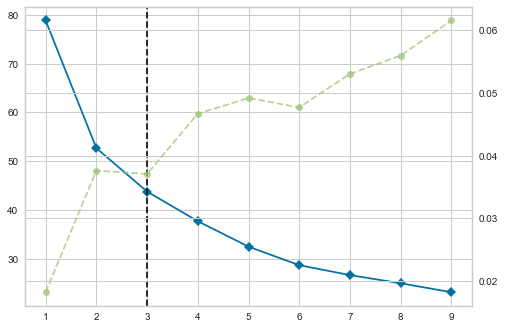

In [51]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledA) 

In [13]:
def Kmeansresults(A,n,minusBSV = False):
    
    fws = get_all_fws()
    if minusBSV == True:
        fws = np.concatenate((fws[0:39],fws[40:]))
    clustering = KMeans(n).fit(A)
    cluster = clustering.labels_

    zlist = defaultdict(list)
    for i in range(len(cluster)):
        zlist[cluster[i]].append(fws[i])
    llist = []
    for i in range(n):
        llist.append(len(zlist[i]))
    llist.sort()
    
    return zlist, llist

In [54]:
zlist, llist = Kmeansresults(scaledA,3)
print(zlist)
print(llist)

for i in range(10):
    zlist, llist = Kmeansresults(scaledA,3)
    print(llist)
##split dead between 50%

defaultdict(<class 'list'>, {1: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BOZ', 'BPH', 'BSV', 'CAN', 'CGS', 'CHA', 'CLO', 'CZP', 'DFO', 'DFT', 'EAB', 'EDI', 'EMT', 'ERI', 'ESV', 'ETR', 'EZT', 'FAR', 'FAU', 'FRA', 'GIS', 'GIU', 'GME', 'GOO', 'IFR', 'IFU', 'IFY', 'IRN', 'ITV', 'ITW', 'IWR', 'IWS', 'JNT', 'JOZ', 'JSN', 'JSR', 'JST', 'JSW', 'KFI', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEI', 'MER', 'MOZ', 'MRT', 'MWF', 'NAB', 'NAT', 'NPT', 'OBW', 'OFF', 'OSO', 'OWE', 'PAR', 'PAU', 'PHI', 'POR', 'PUN', 'PWN', 'RHO', 'RON', 'RSN', 'RTE', 'RWY', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SBT', 'SFO', 'SFW', 'SIV', 'SOD', 'SOF', 'SOR', 'SOS', 'STW', 'SVV', 'SWY', 'THO', 'TOL', 'TSC', 'UEI', 'UFI', 'UOS', 'UOZ', 'USI', 'WEI', 'WEN', 'ZON', 'UOE', 'ETV', 'PTT', 'SYT'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'ATO', 'AT

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

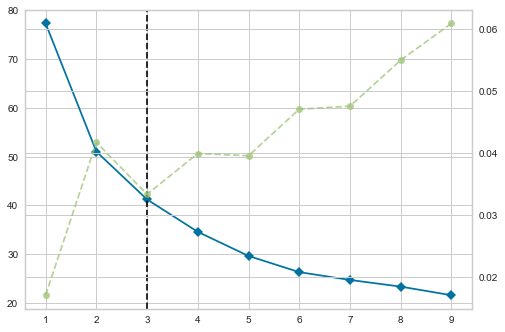

In [11]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledB) 

In [45]:
zlist, llist = Kmeansresults(scaledB,3)
print(zlist)
print(llist)

for i in range(10):
    zlist, llist = Kmeansresults(scaledB,3)
    print(llist)

defaultdict(<class 'list'>, {1: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BOZ', 'BPH', 'BSV', 'CFI', 'CGF', 'CGS', 'CHA', 'CHI', 'CSV', 'DDR', 'DFO', 'DON', 'EAB', 'EEI', 'EPI', 'ERI', 'ESV', 'EWS', 'EZT', 'FAR', 'FER', 'FRA', 'GIS', 'GIU', 'GON', 'IFO', 'IFT', 'IFW', 'IMF', 'ITT', 'ITV', 'ITW', 'IWR', 'JBW', 'JNT', 'JRY', 'JSN', 'JST', 'JSW', 'LAU', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEP', 'MOR', 'MOZ', 'MVY', 'MWW', 'NAB', 'NPO', 'NSI', 'OBW', 'OSI', 'OSO', 'OWE', 'PAR', 'PCR', 'PON', 'PSI', 'PUN', 'PWW', 'RHO', 'RRO', 'RSN', 'RWR', 'SAF', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SFN', 'SFS', 'SGT', 'SIV', 'SOD', 'SOF', 'SOR', 'STT', 'SVR', 'SVV', 'TER', 'THO', 'TON', 'TUN', 'UEI', 'UFI', 'UOV', 'UOZ', 'VSV', 'WEI', 'YUG', 'SVY', 'ETL', 'EWO', 'PTY'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'ATO', 'AT

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

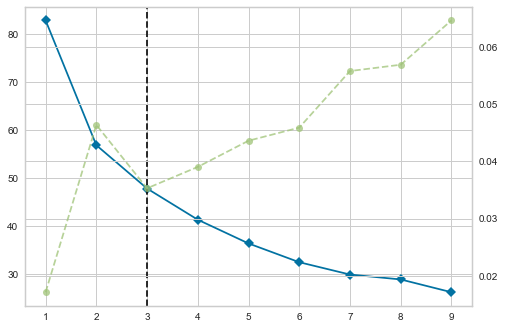

In [12]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledC) 

In [46]:
zlist, llist = Kmeansresults(scaledC,3)
print(zlist)
print(llist)

for i in range(10):
    zlist, llist = Kmeansresults(scaledC,3)
    print(llist)

defaultdict(<class 'list'>, {2: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BOZ', 'BPH', 'BSV', 'CFI', 'CGF', 'CGS', 'CHI', 'CSV', 'DDR', 'DFO', 'DON', 'EAB', 'EEI', 'EPI', 'ERI', 'ESV', 'EWS', 'EZT', 'FAR', 'FER', 'FRA', 'GIS', 'GIU', 'GON', 'IFO', 'IFT', 'IFW', 'IMF', 'ITT', 'ITV', 'ITW', 'IWR', 'JBW', 'JNT', 'JRY', 'JSN', 'JSR', 'JST', 'JSW', 'LAU', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEP', 'MOR', 'MOZ', 'MVY', 'MWW', 'NAB', 'NPO', 'NSI', 'OBW', 'OSI', 'OSO', 'OWE', 'PAR', 'PCR', 'PON', 'PSI', 'PUN', 'PWW', 'RHO', 'RRO', 'RSN', 'RWR', 'SAF', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SFN', 'SFS', 'SGT', 'SIV', 'SOD', 'SOF', 'SOR', 'STT', 'SVR', 'SVV', 'TER', 'THO', 'TON', 'TUN', 'UEI', 'UFI', 'UOV', 'UOZ', 'VSV', 'WEI', 'YUG', 'SVY', 'ETL', 'EWO', 'PTY'], 1: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'AT

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

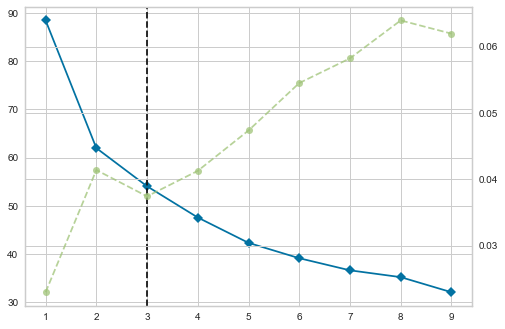

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledD) 

In [48]:
zlist, llist = Kmeansresults(scaledD,3)

for i in range(10):
    zlist, llist = Kmeansresults(scaledD,3)
    print(llist)

defaultdict(<class 'list'>, {2: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BOZ', 'BPH', 'BSV', 'CFI', 'CGF', 'CGS', 'CHI', 'CSV', 'DDR', 'DFO', 'DON', 'EAB', 'EEI', 'EPI', 'ERI', 'ESV', 'EWS', 'EZT', 'FAR', 'FER', 'FRA', 'GIS', 'GIU', 'GON', 'IFO', 'IFT', 'IFW', 'IMF', 'ITT', 'ITV', 'ITW', 'IWR', 'JBW', 'JNT', 'JRY', 'JSN', 'JSR', 'JST', 'JSW', 'LAU', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEP', 'MOR', 'MOZ', 'MVY', 'MWW', 'NAB', 'NPO', 'NSI', 'OBW', 'OSI', 'OSO', 'OWE', 'PAR', 'PCR', 'PON', 'PSI', 'PUN', 'PWW', 'RHO', 'RRO', 'RSN', 'RWR', 'SAF', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SFN', 'SFS', 'SGT', 'SIV', 'SOD', 'SOF', 'SOR', 'STT', 'SVR', 'SVV', 'TER', 'THO', 'TON', 'TUN', 'UEI', 'UFI', 'UOV', 'UOZ', 'VSV', 'WEI', 'YUG', 'SVY', 'ETL', 'EWO', 'PTY'], 0: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'AT

In [14]:
fws = get_all_fws()
print(fws[39])

BSV


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

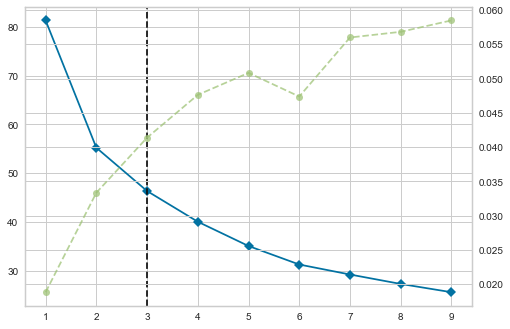

In [56]:
scaler = MinMaxScaler()
AminusBSV = np.concatenate((A[0:39],A[40:]))
# transform data
scaledA1 = scaler.fit_transform(AminusBSV)


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledA1) 

In [61]:
zlist, llist = Kmeansresults(scaledA1,3,True)
print(zlist)
print(llist)

for i in range(10):
    zlist, llist = Kmeansresults(scaledA1,3)
    print(llist)

defaultdict(<class 'list'>, {0: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BPH', 'CAN', 'CGS', 'CHA', 'CLO', 'CZP', 'DFO', 'DFT', 'EAB', 'EDI', 'EMT', 'ERI', 'ESV', 'ETR', 'EZT', 'FAR', 'FAU', 'FRA', 'GIS', 'GIU', 'GME', 'GOO', 'IFR', 'IFU', 'IFY', 'IRN', 'ITV', 'ITW', 'IWR', 'IWS', 'JNT', 'JSN', 'JSW', 'KFI', 'LEV', 'LIO', 'LIT', 'LOS', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEI', 'MER', 'MOZ', 'MRT', 'MWF', 'NAT', 'OFF', 'OWE', 'PAR', 'PAU', 'PHI', 'POR', 'PUN', 'PWN', 'RHO', 'RTE', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SBT', 'SFO', 'SFW', 'SIV', 'SOD', 'SOF', 'SOR', 'SOS', 'STW', 'SVV', 'SWY', 'THO', 'TOL', 'TSC', 'UEI', 'UFI', 'UOS', 'UOZ', 'USI', 'WEN', 'ZON', 'UOE', 'ETV', 'PTT', 'SYT'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'ATO', 'ATV', 'BCT', 'BOF', 'BOZ', 'CGF', 'CHI', 'DON', 'IFO', 'ITH', 'ITR', 'JBW', 'JOZ', 'JRY', 'JSR', 'JS

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

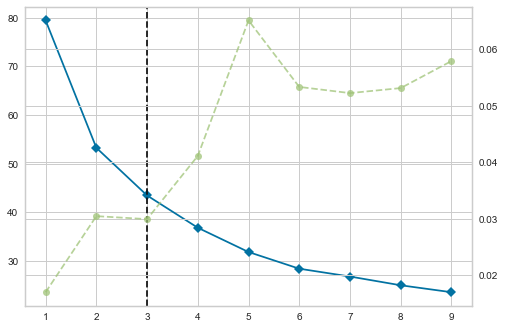

In [58]:
scaler = MinMaxScaler()
BminusBSV = np.concatenate((B[0:39],B[40:]))
# transform data
scaledB1 = scaler.fit_transform(BminusBSV)


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledB1) 

In [77]:
#very confused 
zlist, llist = Kmeansresults(scaledB1,3,True)

temp = zlist
markerlist = []
vbool = True
for i in range(10):
    
    zlist, llist = Kmeansresults(scaledB1,3,True)
    
    
    for n in zlist:
        for t in range(3):
            if len(zlist[n]) > len(temp[t]) + 10: 
                for m in len(temp):
                    if zlist[n][m] == temp[t][m]
            if len(zlist[n]) + 10 < len(temp[t]):
                
    
    
    
    
    '''
    counter = 0 
    for n in zlist:
        print(n)
        while vbool:
            #print(len(zlist[n]))
            #print(len(temp[n]))
            if zlist[n][counter] != temp[n][counter]:
                markerlist.append(zlist[n][counter])
                markerlist.append(temp[n][counter])
                vbool == False
            counter  = counter + 1
            if counter == len(zlist[n]) or counter == len(temp[n]):
                vbool = False'''
                
    print(llist)
    
    temp = zlist
    
#appears to be 1 that just flits among them all 

AttributeError: 'collections.defaultdict' object has no attribute 'sort'

In [74]:
print(markerlist)

['ABW', 'BEC', 'ACO', 'BIK', 'AEI', 'BOF', 'AFG', 'BOG', 'AFN', 'BRE', 'AFR', 'CAS', 'AFS', 'CDO', 'AFT', 'CFI', 'AFV', 'CON', 'AFX', 'CSV', 'AFY', 'DAC', 'ANA', 'DDR', 'APC', 'DOH', 'AST', 'EEI', 'ASV', 'EON', 'ATN', 'EPI', 'ATS', 'EUO', 'ATT', 'EWS', 'AVE', 'FER', 'AVL', 'GON', 'AWO', 'HEU', 'AWW', 'IFT', 'BOZ', 'IFW', 'BPH', 'IHW', 'CAN', 'IMF', 'CGF', 'IRR', 'CGS', 'IRY', 'CHA', 'ISV', 'CHI', 'ITE', 'CLO', 'ITG', 'CZP', 'ITH', 'DFO', 'ITR', 'DFT', 'ITT', 'EAB', 'IWV', 'EDI', 'IWW', 'EMT', 'JST', 'ERI', 'MEL', 'ESV', 'MEP', 'ETR', 'MFI', 'EZT', 'MFS', 'FAR', 'MON', 'FAU', 'MOR', 'FRA', 'MSE', 'GIS', 'MTF', 'GIU', 'MTN', 'GME', 'MTT', 'GOO', 'MTW', 'IFR', 'MWW', 'IFU', 'NES', 'IFY', 'NON', 'IRN', 'NSI', 'ITV', 'OKO', 'ITW', 'PCR', 'IWR', 'POS', 'IWS', 'PWO', 'JNT', 'PWW', 'JOZ', 'RRO', 'JSN', 'RTH', 'JSR', 'RUT', 'JSW', 'RWR', 'KFI', 'SEW', 'LEV', 'SFE', 'LIO', 'SFF', 'LIT', 'SFG', 'LOS', 'SFH', 'LOV', 'SFN', 'LTA', 'SFS', 'LTF', 'SGT', 'LTJ', 'SOV', 'LTL', 'SSY', 'LTN', 'STF', 'MAR'

In [62]:
#figuring which one is moving so much 

defaultdict(<class 'list'>, {1: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BPH', 'BSV', 'CGF', 'CGS', 'CHI', 'CSV', 'DDR', 'DFO', 'DON', 'EAB', 'EEI', 'EPI', 'ERI', 'ESV', 'EWS', 'EZT', 'FAR', 'FER', 'FRA', 'GIS', 'GIU', 'GON', 'IFO', 'IFT', 'IFW', 'IMF', 'ITT', 'ITV', 'ITW', 'IWR', 'JBW', 'JRY', 'JST', 'JSW', 'LAU', 'LEV', 'LIO', 'LIT', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEP', 'MOR', 'MOZ', 'MVY', 'NAB', 'OBW', 'OSO', 'OWE', 'PAR', 'PCR', 'PON', 'PSI', 'PUN', 'PWW', 'RSN', 'SAF', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SFN', 'SFS', 'SGT', 'SIV', 'SOD', 'SOF', 'SOR', 'STT', 'SVR', 'SVV', 'TER', 'THO', 'TON', 'TUN', 'UEI', 'UFI', 'UOV', 'UOZ', 'WEI', 'YUG', 'SVY', 'ETL', 'EWO', 'PTY'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'ATO', 'ATV', 'BCT', 'BOF', 'BOZ', 'CFI', 'CHA', 'DOH', 'HEU', 'ITG', 'ITH', 'IWW', 'JNT', 'JOZ', 'JSN', 'JS

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

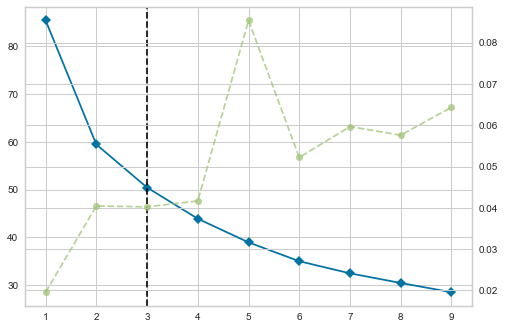

In [80]:
scaler = MinMaxScaler()
CminusBSV = np.concatenate((C[0:39],C[40:]))
# transform data
scaledC1 = scaler.fit_transform(CminusBSV)


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledC1) 

In [81]:
zlist, llist = Kmeansresults(scaledC1,3,True)
print(zlist)
print(llist)

for i in range(10):
    zlist, llist = Kmeansresults(scaledC1,3)
    print(llist)

defaultdict(<class 'list'>, {0: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BOZ', 'BPH', 'CAN', 'CGF', 'CGS', 'CHA', 'CLO', 'CZP', 'DFO', 'DFT', 'EAB', 'EDI', 'EMT', 'ERI', 'ESV', 'ETR', 'EZT', 'FAR', 'FAU', 'FRA', 'GIS', 'GIU', 'GME', 'GOO', 'IFR', 'IFU', 'IFY', 'IRN', 'IRY', 'ITV', 'ITW', 'IWR', 'IWS', 'JNT', 'JOZ', 'JSN', 'JSR', 'JST', 'JSW', 'KFI', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEI', 'MER', 'MOZ', 'MRT', 'MWF', 'NAB', 'NAT', 'NPT', 'OBW', 'OFF', 'OSO', 'OWE', 'PAR', 'PAU', 'PHI', 'POR', 'POS', 'PUN', 'PWN', 'RHO', 'RON', 'RSN', 'RTE', 'RWY', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SBT', 'SFO', 'SFW', 'SIV', 'SOD', 'SOF', 'SOR', 'SOS', 'STW', 'SVV', 'SWY', 'THO', 'TOL', 'TSC', 'UEI', 'UFI', 'UOS', 'UOZ', 'USI', 'WEI', 'WEN', 'ZON', 'UOE', 'ETV', 'PTT', 'SYT'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AH

In [ ]:
#consistent with tge other C

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

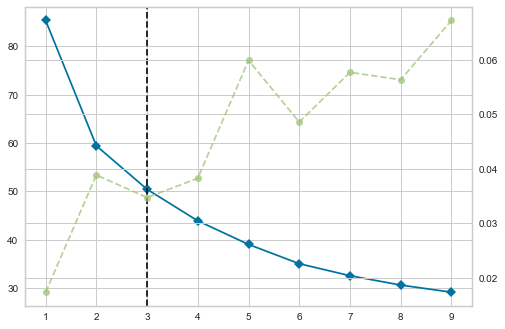

In [82]:
scaler = MinMaxScaler()
DminusBSV = np.concatenate((C[0:39],C[40:]))
# transform data
scaledD1 = scaler.fit_transform(CminusBSV)


model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaledD1) 

In [84]:
zlist, llist = Kmeansresults(scaledD1,3,True)
print(zlist)
print(llist)

for i in range(10):
    zlist, llist = Kmeansresults(scaledD1,3)
    print(llist)

defaultdict(<class 'list'>, {1: ['ABW', 'ACO', 'AEI', 'AFG', 'AFN', 'AFR', 'AFS', 'AFT', 'AFV', 'AFX', 'AFY', 'ANA', 'APC', 'AST', 'ASV', 'ATN', 'ATS', 'ATT', 'AVE', 'AVL', 'AWO', 'AWW', 'BCT', 'BOZ', 'BPH', 'CAN', 'CGF', 'CGS', 'CHA', 'CLO', 'CZP', 'DFO', 'DFT', 'EAB', 'EDI', 'EMT', 'ERI', 'ESV', 'ETR', 'EZT', 'FAR', 'FAU', 'FRA', 'GIS', 'GIU', 'GME', 'GOO', 'IFR', 'IFU', 'IFY', 'IRN', 'ITV', 'ITW', 'IWR', 'IWS', 'JNT', 'JOZ', 'JSN', 'JSR', 'JST', 'JSW', 'KFI', 'LEV', 'LIO', 'LIT', 'LOS', 'LOV', 'LTA', 'LTF', 'LTJ', 'LTL', 'LTN', 'MAR', 'MAZ', 'MEI', 'MER', 'MOZ', 'MRT', 'MWF', 'NAB', 'NAT', 'NPT', 'OBW', 'OFF', 'OSO', 'OWE', 'PAR', 'PAU', 'PHI', 'POR', 'PUN', 'PWN', 'RHO', 'RON', 'RSN', 'RTE', 'RWY', 'SAO', 'SAS', 'SAT', 'SAV', 'SBE', 'SBN', 'SBS', 'SBT', 'SFO', 'SFW', 'SIV', 'SOD', 'SOF', 'SOR', 'SOS', 'STW', 'SVV', 'SWY', 'THO', 'TOL', 'TSC', 'UEI', 'UFI', 'UOS', 'UOZ', 'USI', 'WEI', 'WEN', 'ZON', 'UOE', 'ETV', 'PTT', 'SYT'], 2: ['AEL', 'AEN', 'AET', 'AFI', 'AFO', 'AHT', 'APD', 'AT

In [24]:
#without BSV goetzke is less consistent than before 

In [ ]:
#without or without BSV they are all 3. Time to check and see if its now in a group

In [ ]:
#check to see how similar they are inlcuding BSV 

In [6]:
vzlist, vllist = Kmeansresults(scaledA,3,False)
szlist, sllist = Kmeansresults(scaledB,3,False)
czlist, cllist = Kmeansresults(scaledC,3,False)
gzlist, gllist = Kmeansresults(scaledD,3,False)

NameError: name 'Kmeansresults' is not defined

In [102]:
print(vllist)
print(sllist)


counter0  = 0 
counter1 = 0
counter2 = 0 


for n in vzlist:
    print(n)
    if len(vzlist[n]) < len(szlist[0]) + 20 and len(vzlist[n]) > len(szlist[0]) - 20:
        print('check 1')
        for i in range(len(vzlist[n])):
            if (vzlist[n][i] in szlist[0]):
                counter0 = counter0 + 1
    if len(vzlist[n]) < len(szlist[1]) + 20 and len(vzlist[n]) > len(szlist[1]) - 20:
        print('check 2')
        for i in range(len(vzlist[n])):
            if (vzlist[n][i] in szlist[1]):
                counter1 = counter1 + 1
    if len(vzlist[n]) < len(szlist[2]) + 20 and len(vzlist[n]) > len(szlist[2]) - 20:
        print('check 3')
        for i in range(len(vzlist[n])):
            if (vzlist[n][i] in szlist[2]):
                counter2 = counter2 + 1

[50, 89, 114]
[27, 97, 129]
2
check 1
check 2
0
1
check 2


In [103]:
print(counter0)
print(counter1)
print(counter2)

114
89
0


In [153]:
def compare3(A,B,vbool=False):
    
    
    #counters 
    counter0  = 0 
    counter1 = 0
    counter2 = 0 

    Azlist, Allist = Kmeansresults(A,3,vbool)
    Bzlist, Bllist = Kmeansresults(B,3,vbool)
    
    print(Allist)
    print(Bllist)
    
    for n in Azlist:
    
        if len(Azlist[n]) < len(Bzlist[0]) + 30 and len(Azlist[n]) > len(Bzlist[0]) - 30:
        
            for i in range(len(Azlist[n])):
                if (Azlist[n][i] in Bzlist[0]):
                    counter0 = counter0 + 1
        if len(Azlist[n]) < len(Bzlist[1]) + 30 and len(Azlist[n]) > len(Bzlist[1]) - 30:
            for i in range(len(Azlist[n])):
                if (Azlist[n][i] in Bzlist[1]):
                    counter1 = counter1 + 1
        if len(Azlist[n]) < len(Bzlist[2]) + 30 and len(Azlist[n]) > len(Bzlist[2]) - 30:
            for i in range(len(Azlist[n])):
                if (Azlist[n][i] in Bzlist[2]):
                    counter2 = counter2 + 1
    
    return counter0, counter1, counter2

In [154]:
counter0,counter1,counter2 = compare3(scaledA,scaledB)

[28, 96, 129]
[26, 97, 130]


In [155]:
print(counter0)
print(counter1)
print(counter2)

26
128
96


In [116]:
#takeways, the two larger groups of vertex are all in the sastre rings

In [118]:
#vertex and crum

counter0,counter1,counter2 = compare3(scaledA,scaledC)

print(counter0)
print(counter1)
print(counter2)

[50, 89, 114]
[26, 96, 130]
36
97
0


In [120]:
114-20

94

In [173]:
def compareall(A,B,nclusters,vbool=False):
    
    #make dictionaries 
    counter  = defaultdict(int)
    Azlist, Allist = Kmeansresults(A,nclusters,vbool)
    Bzlist, Bllist = Kmeansresults(B,nclusters,vbool)
    
    print(Allist)
    print(Bllist)
    
    z = 0
    
    for n in range(nclusters):
        for t in range(z,nclusters):
            if len(Azlist[n]) < len(Bzlist[t]) + 30 and len(Azlist[n]) > len(Bzlist[t]) - 30:
                print('check 1',t)
                for i in range(len(Azlist[n])):
                    if (Azlist[n][i] in Bzlist[n]):
                        counter[n] = counter[n] + 1
                        print(counter)
        z = z + 1
    return counter

In [174]:
counter = compareall(scaledA,scaledB,3)

[50, 89, 114]
[26, 97, 130]
check 1 1
check 1 2
defaultdict(<class 'int'>, {1: 1})
defaultdict(<class 'int'>, {1: 2})
defaultdict(<class 'int'>, {1: 3})
defaultdict(<class 'int'>, {1: 4})
defaultdict(<class 'int'>, {1: 5})
defaultdict(<class 'int'>, {1: 6})
defaultdict(<class 'int'>, {1: 7})
defaultdict(<class 'int'>, {1: 8})


In [175]:
print(counter)

defaultdict(<class 'int'>, {1: 8})


In [176]:
counter = compareall(scaledA,scaledC,3)
print(counter)


'''z = 0
    
    for n in range(nclusters):
        for t in range(z,nclusters):
            if len(Azlist[n]) < len(Bzlist[t]) + 30 and len(Azlist[n]) > len(Bzlist[t]) - 30:
                print('check 1',t)
                for i in range(len(Azlist[n])):
                    if (Azlist[n][i] in Bzlist[n]):
                        counter[n] = counter[n] + 1
                        print(counter)'''

[40, 96, 117]
[25, 96, 131]
check 1 1
defaultdict(<class 'int'>, {0: 1})
defaultdict(<class 'int'>, {0: 2})
defaultdict(<class 'int'>, {0: 3})
defaultdict(<class 'int'>, {0: 4})
defaultdict(<class 'int'>, {0: 5})
defaultdict(<class 'int'>, {0: 6})
defaultdict(<class 'int'>, {0: 7})
defaultdict(<class 'int'>, {0: 8})
defaultdict(<class 'int'>, {0: 9})
defaultdict(<class 'int'>, {0: 10})
defaultdict(<class 'int'>, {0: 11})
defaultdict(<class 'int'>, {0: 12})
defaultdict(<class 'int'>, {0: 13})
defaultdict(<class 'int'>, {0: 14})
defaultdict(<class 'int'>, {0: 15})
defaultdict(<class 'int'>, {0: 16})
defaultdict(<class 'int'>, {0: 17})
defaultdict(<class 'int'>, {0: 18})
defaultdict(<class 'int'>, {0: 19})
defaultdict(<class 'int'>, {0: 20})
defaultdict(<class 'int'>, {0: 21})
defaultdict(<class 'int'>, {0: 22})
defaultdict(<class 'int'>, {0: 23})
defaultdict(<class 'int'>, {0: 24})
defaultdict(<class 'int'>, {0: 25})
defaultdict(<class 'int'>, {0: 26})
defaultdict(<class 'int'>, {0: 27})

In [19]:
def compareall2(A,B,nclusters,vbool=False):
    
    #make dictionaries 
    counter  = defaultdict(int)
    Azlist, Aist = Kmeansresults(A,nclusters,vbool)
    Bzlist, Bist = Kmeansresults(B,nclusters,vbool)
    
    
    #sort dictionaries
    #note this works under the assumption that the clusters of equal size are most similar 
    #this function will either prove or disprove this assumption
    
    Alist = defaultdict(list)
    Blist = defaultdict(list)
    m = 0
    for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
    m = 0
    for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
        Blist[m] = Bzlist[k]
        m = m + 1
    
    for n in Alist:
        for i in range(len(Alist[n])):
            if (Alist[n][i] in Blist[n]):
                counter[n] = counter[n] + 1
    
    return Alist, Blist, counter, Aist, Bist

In [20]:
Alist, Blist, counter, Aist, Bist = compareall2(scaledA, scaledB,3)

In [21]:
print('Vertex is ',Aist)
print('Sastre is ',Bist)
print(counter)

Vertex is  [50, 89, 114]
Sastre is  [26, 97, 130]
defaultdict(<class 'int'>, {0: 114, 1: 89, 2: 26})


In [ ]:
#these results show that the Each one is a subset of the other

In [221]:
d = {2:['0'],0:['1'],1:['2']}
l = defaultdict(list)
l[0] = d[0]
print(int(l[0][0]))

1


In [193]:
#testing with compareall two

In [194]:
#vector and crum

defaultdict(<class 'list'>, {0: ['1']})


In [18]:
Alist, Clist, counter, Aist, Cist = compareall2(scaledA, scaledC,3)
print('Vertex is ',Aist)
print('Crum is ',Cist)
print(counter)

[28, 96, 129]
[26, 96, 131]
Vertex is  [28, 96, 129]
Crum is  [26, 96, 131]
defaultdict(<class 'int'>, {0: 129, 1: 96, 2: 26})


In [ ]:
#crum and vertex are not that similar which is weird 

In [23]:
Alist, Dlist, counter, Aist, Dist = compareall2(scaledA, scaledD,3)
print('Vertex is ',Aist)
print('Goetzke is ',Dist)
print(counter)

Vertex is  [50, 89, 114]
Goetzke is  [81, 82, 90]
defaultdict(<class 'int'>, {0: 34, 1: 82, 2: 1})


In [ ]:
#goetzke and vertex is pretty similar

In [24]:
Blist, Clist, counter,Bist,Cist = compareall2(scaledB, scaledC,3)
print('Sastre is ',Bist)
print('Crum is ',Cist)
print(counter)

Sastre is  [26, 97, 130]
Crum is  [26, 96, 131]
defaultdict(<class 'int'>, {0: 129, 1: 96, 2: 25})


In [212]:
#sastre and crum very disimilar as well

In [31]:
Blist, Dlist, counter, Bist, Dist = compareall2(scaledB, scaledD,3)
print('Sastre is ',Bist)
print('Goetzke is ',Dist)
print(len(Blist[0]),len(Blist[1]),len(Blist[2]))
print(counter)

Sastre is  [26, 97, 130]
Goetzke is  [40, 96, 117]
130 97 26
defaultdict(<class 'int'>, {0: 115, 1: 93, 2: 24})


In [214]:
#sastre and vertex are ok in matching the first group matches well

In [34]:
Clist, Dlist, counter, Cist, Dist = compareall2(scaledB, scaledD,3)
print('Crum is ',Cist)
print('Goetzke is ',Dist)
print(len(Clist[0]),len(Clist[1]),len(Clist[2]))
print(counter)

Crum is  [26, 97, 130]
Goetzke is  [81, 82, 90]
130 97 26
defaultdict(<class 'int'>, {0: 50, 1: 82, 2: 1})


In [3]:
fws = get_all_fws
iza_values =pd.read_csv('../data/iza_data.csv')
fws = iza_values['Framework'].values
rings = iza_values['Rings'].values
ntsite = iza_values['Number of T Sites'].values
accessiblevolume = iza_values['Accessible Volume %'].values
mdiametera = iza_values['Max diameter along a'].values
mdiameterb = iza_values['Max diameter along b'].values
mdiameterc = iza_values['Max diameter along c'].values
alpha = iza_values['alpha'].values
beta = iza_values['beta'].values
gamma = iza_values['gamma'].values
mdiameter = iza_values['Max Diameter (Å)'].values
density = iza_values['Density (T sites/ 1000 Å^3)'].values

print(iza_values.columns)

Index(['Unnamed: 0', 'Framework', 'a (Å)', 'b', 'c', 'alpha', 'beta', 'gamma',
       'Volume (Å^3)', 'Density (T sites/ 1000 Å^3)', 'Rings',
       'Max Diameter (Å)', 'Max diameter along a', 'Max diameter along b',
       'Max diameter along c', 'Accessible Volume %', 'Number of T Sites'],
      dtype='object')


In [4]:
def properties(A,values,nclusters,vbool=False):
    '''Arguments:
    
        A: the assembled matrix
        nclusters: number of clusters
        values: data framework to be texted'''
    #get all the frameworks
    fws = get_all_fws()
    #get the clusters
    Azlist, Aist = Kmeansresults(A,nclusters,vbool)
    #create a values dictionary to store the frameworks IZa values
    value_dict = defaultdict(list)
    #go through all the clusters
    for k in Azlist:
        #go through all the frameworks in each cluster
        for i in range(len(Azlist[k])):
            #find the index for the framework
            idx = fws.index(Azlist[k][i])
            if isNaN(values[idx]) != True:
                #add the framework's values to the dictionary
                value_dict[k].append(int(values[idx]))
    
    
    #list of the averages
    avg = []
    #list of the standard deviations
    stdev = []
    for k in value_dict:
        x = sum(value_dict[k])/len(value_dict[k])
        avg.append(x)
        y = np.std(value_dict[k])
        stdev.append(y)
                   
    return avg, stdev





In [42]:
x, y = properties(scaledA,alpha,3,vbool=False)
print('Vertex')
print(x)
print(y)

Vertex
[90.01769911504425, 90.0, 89.78823529411764]
[0.1873098273320064, 0.0, 1.940855588451886]


In [264]:
x, y = properties(scaledB,alpha,3,vbool=False)
print('Sastre')
print(x)
print(y)

Sastre
[90.015625, 90.0, 89.80645161290323]
[0.17608480733726006, 0.0, 1.8564509122500847]


In [43]:
x, y = properties(scaledC,alpha,3,vbool=False)
print('Crum')
print(x)
print(y)

Crum
[90.01492537313433, 90.0, 89.79775280898876]
[0.17212779992045965, 0.0, 1.8972468241982412]


In [44]:
x, y = properties(scaledD,alpha,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Goetzke
[90.02439024390245, 90.0, 89.76923076923077]
[0.21951219512195125, 0.0, 2.024991781705875]


In [268]:
x, y = properties(scaledA,ntsite,3,vbool=False)
print('Vertex')
print(x)
print(y)

Vertex
[4.87719298245614, 4.74, 7.49438202247191]
[4.039585593817182, 3.3929927792437167, 11.420584210942422]


In [269]:
x, y = properties(scaledB,ntsite,3,vbool=False)
print('Sastre')
print(x)
print(y)

Sastre
[4.953846153846154, 4.115384615384615, 7.309278350515464]
[3.961082871487657, 2.846413709550521, 11.036360546774343]


In [270]:
x, y = properties(scaledC,ntsite,3,vbool=False)
print('Crum')
print(x)
print(y)

Crum
[5.084615384615384, 5.038461538461538, 6.916666666666667]
[4.682265420440796, 4.7513623085366, 10.612165450818958]


In [271]:
x, y = properties(scaledD,ntsite,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Goetzke
[4.967391304347826, 4.6911764705882355, 7.354838709677419]
[4.279503950725155, 3.236998214310037, 11.208335186911457]


In [272]:
#no correlation on number of tsites

In [273]:
x, y = properties(scaledA,density,3,vbool=False)
print('Vertex')
print(x)
print(y)

Vertex
[16.3515625, 17.321428571428573, 15.802197802197803]
[1.7166002180454685, 1.7331550797929898, 2.060725254918497]


In [274]:
x, y = properties(scaledB,density,3,vbool=False)
print('Sastre')
print(x)
print(y)

Sastre
[16.34108527131783, 17.46153846153846, 15.804347826086957]
[1.7140374568782082, 1.7148843699698426, 2.049597682869911]


In [275]:
x, y = properties(scaledC,density,3,vbool=False)
print('Crum')
print(x)
print(y)

Crum
[16.0, 17.0, 16.397849462365592]
[1.8157298807917437, 1.697056274847714, 2.016809920867188]


In [47]:
x, y = properties(scaledD,density,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Goetzke
[16.32758620689655, 16.897435897435898, 15.902173913043478]
[1.690622523933252, 1.9973684199128667, 2.0433337136665726]


In [276]:
#slghtly below for the first two groups not much change in deviation 

In [277]:
x, y = properties(scaledD,density,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Goetzke
[16.37037037037037, 16.40909090909091, 15.974358974358974]
[1.7458553702803963, 1.9922370000737386, 1.9412813569997642]


In [49]:
x, y = properties(scaledA,accessiblevolume,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,accessiblevolume,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,accessiblevolume,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,accessiblevolume,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[10.534351145038167, 9.178571428571429, 14.314606741573034]
[7.41290159621524, 5.757315665609224, 8.710829506312498]
Sastre
[10.503875968992247, 8.73076923076923, 14.290322580645162]
[7.403250942102941, 5.70800849217532, 8.606799818849524]
Crum
[10.407692307692308, 9.384615384615385, 14.282608695652174]
[7.420031260400824, 5.64376390416158, 8.653129726536648]
Goetzke
[10.758241758241759, 10.0, 14.067415730337078]
[7.326514634449705, 7.551782025767553, 8.417207832979578]


In [279]:
#erratic but too hogh a standard deviation 

In [281]:
x, y = properties(scaledA,accessiblevolume,10,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,accessiblevolume,10,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,accessiblevolume,10,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,accessiblevolume,10,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[11.060240963855422, 10.947368421052632, 7.333333333333333, 12.537037037037036, 15.0, 9.0, 12.945945945945946, 13.0, 20.5, 7.0]
[7.3359149487100455, 8.094661556011541, 4.346134936801766, 8.510805687070567, 9.302980949429841, 6.9602043392737, 7.853200228882234, 5.354126134736337, 1.5, 7.842193570679061]
Sastre
[11.414634146341463, 13.7, 10.0, 7.476190476190476, 13.627450980392156, 16.0, 10.0, 12.63888888888889, 8.333333333333334, 7.0]
[7.194088392074452, 9.581753492967767, 6.465886815255298, 4.777118553898839, 9.117878976599261, 8.85330177848651, 7.916228058025278, 7.554074609763696, 4.988876515698588, 7.842193570679061]
Crum
[12.476190476190476, 7.636363636363637, 10.806451612903226, 8.733333333333333, 13.076923076923077, 11.6, 17.444444444444443, 10.631578947368421, 11.666666666666666, 11.8]
[7.7374725024146995, 5.958534402972342, 7.284182398553774, 8.629149565410385, 8.566136715279068, 6.967065379340142, 8.447367914999205, 8.237977053134939, 3.39934634239519, 3.124099870362661

In [282]:
#std's go down a little but thats prob expected

In [283]:
x, y = properties(scaledA,mdiametera,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,mdiametera,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,mdiametera,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,mdiametera,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[2.7899159663865545, 2.6486486486486487, 3.4456521739130435]
[1.4887474266984904, 1.2989853881835585, 1.801956246361055]
Sastre
[2.813953488372093, 2.423076923076923, 3.4516129032258065]
[1.4773086878093484, 1.245702672361665, 1.7931538206048125]
Crum
[3.0390625, 3.12, 2.9574468085106385]
[1.6554943736218948, 1.4510685717773644, 1.6237263002841629]
Goetzke
[2.7815126050420167, 2.7674418604651163, 3.453488372093023]
[1.4790393422392567, 1.4601243862643964, 1.789224703764864]


In [284]:
x, y = properties(scaledA,mdiameterb,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,mdiameterb,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,mdiameterb,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,mdiameterb,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[2.725663716814159, 3.06, 3.3529411764705883]
[1.5007242358429354, 1.678213335663854, 1.6922375188102894]
Sastre
[2.798449612403101, 2.8076923076923075, 3.3548387096774195]
[1.5817753001530492, 1.359276695928638, 1.7016447533073846]
Crum
[3.2109375, 2.56, 2.851063829787234]
[1.7031787548856256, 1.2986146464598343, 1.5707258574716385]
Goetzke
[2.741573033707865, 2.9873417721518987, 3.325]
[1.5104734720724549, 1.6419629413946328, 1.6865274975522933]


In [285]:
x, y = properties(scaledA,mdiameterc,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,mdiameterc,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,mdiameterc,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,mdiameterc,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[3.185840707964602, 3.58, 4.047058823529412]
[1.7271833563080279, 2.3502340308999017, 2.0228453015954657]
Sastre
[3.1627906976744184, 3.576923076923077, 4.10752688172043]
[1.7243837127364303, 2.2390430119735205, 2.1625471122540274]
Crum
[3.483050847457627, 3.738095238095238, 3.6091954022988504]
[1.9903711043440506, 1.9155941986200649, 2.053067913725619]
Goetzke
[3.259259259259259, 3.438202247191011, 4.012820512820513]
[1.7692697648142497, 2.0930868348976626, 2.0537245074254087]


In [287]:
x, y = properties(scaledA,mdiameter,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,mdiameter,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,mdiameter,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,mdiameter,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[6.224137931034483, 5.9, 7.173913043478261]
[1.707418937827179, 1.8411952639521971, 2.556359060189408]
Sastre
[6.248062015503876, 5.576923076923077, 7.172043010752688]
[1.7388894600559324, 1.7135899546111897, 2.542641315318605]
Crum
[6.46875, 6.08, 6.73404255319149]
[1.9642806412272154, 2.076920797719547, 2.366321914373559]
Goetzke
[6.205882352941177, 5.695652173913044, 7.224719101123595]
[1.7410174808174992, 1.6794093839850404, 2.5736469511106197]


In [288]:
#standard deviation doesnt increase as much as expected from a b and c, signficnat? 

In [50]:
x, y = properties(scaledA,gamma,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,gamma,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,gamma,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,gamma,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[96.4375, 94.28571428571429, 97.82608695652173]
[12.244737389997386, 10.497813183356477, 13.173267310907056]
Sastre
[96.62015503875969, 93.46153846153847, 97.74193548387096]
[12.371004984117024, 9.584565995674701, 13.127090289919872]
Crum
[96.33846153846154, 94.61538461538461, 97.82608695652173]
[12.175987621388789, 10.824036368823299, 13.173267310907056]
Goetzke
[96.71264367816092, 96.25, 97.07865168539325]
[12.399395652659676, 12.183492931011205, 12.737827164735629]


In [51]:
a = iza_values['a (Å)'].values
b = iza_values['b'].values
c = iza_values['c'].values

In [52]:
x, y = properties(scaledA,a,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,a,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,a,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,a,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[13.690265486725664, 15.26, 15.847058823529412]
[5.331621556814777, 7.391373350061543, 7.126596221368385]
Sastre
[13.875968992248062, 15.038461538461538, 15.870967741935484]
[5.403139701571433, 7.1869581092354595, 7.460614588036127]
Crum
[14.007462686567164, 15.32, 15.696629213483146]
[5.888891982870898, 7.187322171713189, 7.033474526768199]
Goetzke
[13.666666666666666, 14.97752808988764, 15.602564102564102]
[5.584369721390694, 6.634905193246416, 7.073496476265258]


In [53]:
x, y = properties(scaledA,b,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,b,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,b,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,b,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[14.734513274336283, 13.52, 17.070588235294117]
[6.556787605310334, 5.076376660571987, 8.52510235963267]
Sastre
[14.705426356589147, 12.923076923076923, 16.763440860215052]
[6.462057536800313, 4.890517330846872, 8.285753869910634]
Crum
[14.646153846153846, 13.115384615384615, 16.815217391304348]
[6.466316914432034, 4.790430549759699, 8.315686261290724]
Goetzke
[15.01086956521739, 13.388059701492537, 17.01123595505618]
[6.968086514864677, 4.809676887029914, 8.383362847313629]


In [54]:
x, y = properties(scaledA,c,3,vbool=False)
print('Vertex')
print(x)
print(y)

x, y = properties(scaledB,c,3,vbool=False)
print('Sastre')
print(x)
print(y)

x, y = properties(scaledC,c,3,vbool=False)
print('Crum')
print(x)
print(y)

x, y = properties(scaledD,c,3,vbool=False)
print('Goetzke')
print(x)
print(y)

Vertex
[14.787610619469026, 14.42, 19.141176470588235]
[8.99011386959063, 7.678775944120261, 13.965632557588073]
Sastre
[15.279069767441861, 11.115384615384615, 18.913978494623656]
[8.996103156527521, 5.1165412226268865, 13.596058816965167]
Crum
[15.184615384615384, 11.461538461538462, 18.98913043478261]
[9.01006669093786, 4.994079334809056, 13.650525205071457]
Goetzke
[13.987654320987655, 16.651685393258425, 18.0]
[9.286248730539382, 12.532296366413831, 10.220642761663205]


In [5]:
A = weight_avg('../Data/vertex_rings.txt')
B = weight_avg('../Data/sastre_rings.txt')
C = weight_avg('../Data/crum_rings.txt')
D = weight_avg('../Data/goetzke_rings.txt')


In [6]:
scaler = MinMaxScaler()
# transform data
scaledA = scaler.fit_transform(A)
scaledB = scaler.fit_transform(B)
scaledC = scaler.fit_transform(C)
scaledD = scaler.fit_transform(D)

In [11]:
def similarrating(A,B,nclusters,vbool=False):
    #make dictionaries 
    Azlist, Aist = Kmeansresults(A,nclusters,vbool)
    Bzlist, Bist = Kmeansresults(B,nclusters,vbool)
    print(Aist,Bist)
    
    Alist = defaultdict(list)
    Blist = defaultdict(list)
    m = 0
    for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
    m = 0
    for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
        Blist[m] = Bzlist[k]
        m = m + 1
    
    #holds percentage list maximum will be taken at the end
    per_list = []
    
    #check for 
    
    temp = []
    for t in Alist:
        for n in Blist:
            count = 0
            for i in range(len(Alist[t])):
                if (Alist[t][i] in Blist[n]):
                    count = count + 1
            if len(Blist[t]) > len(Alist[n]):
                temp.append(count/len(Blist[n]))
            else:
                temp.append(count/len(Alist[t]))
            n = n + 1
        per_list.append(sum(temp)/len(temp))
                
            
        
    return per_list

In [52]:
p = similarrating(scaledA,scaledB,3)
print(p)

[26, 97, 130] [50, 89, 114]
[0.19909664694280038, 0.19197823325077013, 0.1814982567111653]


In [12]:
'''Azlist, Aist = Kmeansresults(scaledA,3,False)
Bzlist, Bist = Kmeansresults(scaledB,3,False)

print(Aist)
print(Bist)
Alist = defaultdict(list)
Blist = defaultdict(list)

m = 0
for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
m = 0
for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
    Blist[m] = Bzlist[k]
    m = m + 1

    
    
    
    
    
    
    
# combinations
unique_combinations = []
 
# Getting all permutations of list_1
# with length of list_2
permut = itertools.permutations(Alist, len(Blist))
 
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, Blist)
    unique_combinations.append(list(zipped))
    
print(unique_combinations[0][0][0])   

nclusters = 3 
array_values = np.zeros([nclusters,nclusters])
for n in range(nclusters):
    for i in range(nclusters):
        print(unique_combinations[n][i])   
        a = unique_combinations[n][i][0]
        b = unique_combinations[n][i][1]
        c = list(set(Alist[a]).intersection(Blist[b]))
        array_values[n,i] = len(c)
print(array_values)
for t in range(nclusters):
    print(sum(array_values[t])/253)'''
        
                
                
def compare4(A,B,nclusters,vbool=False):
    #get data 
    Azlist, Aist = Kmeansresults(A,nclusters,False)
    Bzlist, Bist = Kmeansresults(B,nclusters,False)

    #print(Aist)
    #print(Bist)
    #make default dictionaries to reorganzie the zlist
    Alist = defaultdict(list)
    Blist = defaultdict(list)
    
    #sort the dictionaries numerically
    m = 0
    for k in (sorted(Azlist, key=lambda k: len(Azlist[k]), reverse=True)):
        Alist[m] = Azlist[k]
        m = m + 1
    m = 0
    for k in sorted(Bzlist, key=lambda k: len(Bzlist[k]), reverse=True):
        Blist[m] = Bzlist[k]
        m = m + 1   
    # combinations
    unique_combinations = []
    print('check 1')
    # Getting all permutations of list_1
    # with length of list_2
    permut = itertools.permutations(Alist, len(Blist))
    
    print('check 1.5')
    # zip() is called to pair each permutation
    # and shorter list element into combination
    for comb in permut:
        print(comb)
        zipped = zip(comb, Blist)
        print('zipped')
        unique_combinations.append(list(zipped))
    print('check 2')   
    
    #create an array to store values
    array_values = np.zeros([nclusters,nclusters])
    #print('')
    #loop over unique combinations 
    for n in range(nclusters):
        for i in range(nclusters):
            #index into the first part of the ordered pair
            a = unique_combinations[n][i][0]
            #index into the second part of the ordered pair
            b = unique_combinations[n][i][1]
            #find what is in common with the two lists 
            c = list(set(Alist[a]).intersection(Blist[b]))
            #add the value to the array
            array_values[n,i] = len(c)
    #print(array_values)
    #print('')
    print('check 4')
    #store results 
    temp = []
    #print results 
    for t in range(nclusters):
        #print(sum(array_values[t])/253)
        temp.append(sum(array_values[t])/253)
        
    return temp

In [18]:
for i in range(10,25):
    x = 0 
    for n in range(10):
        x = max(compare4(scaledA,scaledA,i,False)) + x
    print(i,'is',x/20)

KeyboardInterrupt: 

In [10]:
x = 0
for i in range(10):
    x = max(compare4(scaledA,scaledA,10,False)) + x
print(x/10)

check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
check 1
check 2
check 4
0.383399209486166


In [96]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0

for i in keys:
    d = 0
    for k in keys:
        x = 0
        for t in range(50):
            x = max(compare4(i,k,5,False)) + x 
        print(x/10)
        compare_array[c,d] = x/50
        print(compare_array)
        d = d + 1
    c = c + 1
#print(compare_array) 

[15, 24, 52, 63, 99]
[15, 25, 52, 63, 98]
[15, 24, 54, 61, 99]
[15, 25, 52, 63, 98]
[14, 26, 55, 61, 97]
[15, 24, 52, 63, 99]
[15, 24, 54, 61, 99]
[15, 24, 57, 58, 99]
[15, 24, 52, 63, 99]
[14, 25, 52, 63, 99]
[10, 25, 58, 59, 101]
[15, 24, 52, 63, 99]
[15, 24, 52, 63, 99]
[14, 26, 52, 63, 98]
[15, 24, 52, 63, 99]
[14, 25, 52, 63, 99]
[15, 24, 52, 63, 99]
[15, 24, 52, 63, 99]
[15, 24, 52, 63, 99]
[15, 24, 52, 63, 99]
[15, 24, 52, 63, 99]
[15, 24, 54, 61, 99]
[15, 24, 54, 61, 99]
[15, 24, 52, 63, 99]
[14, 25, 52, 63, 99]
[15, 24, 54, 61, 99]
[14, 26, 57, 59, 97]
[15, 24, 52, 63, 99]
[15, 24, 52, 63, 99]
[14, 26, 52, 63, 98]
[15, 24, 52, 63, 99]
[14, 25, 52, 63, 99]
[14, 26, 52, 63, 98]
[14, 41, 52, 61, 85]
[15, 24, 54, 61, 99]
[15, 24, 52, 63, 99]
[15, 24, 56, 59, 99]
[14, 25, 52, 63, 99]
[15, 24, 52, 63, 99]
[15, 25, 52, 63, 98]
[10, 25, 52, 65, 101]
[15, 40, 54, 60, 84]
[15, 25, 54, 61, 98]
[15, 24, 56, 59, 99]
[15, 25, 57, 58, 98]
[15, 24, 52, 63, 99]
[15, 24, 54, 61, 99]
[15, 24, 52

[15, 24, 52, 63, 99]
[16, 17, 50, 66, 104]
[14, 26, 52, 63, 98]
[16, 17, 57, 62, 101]
[19, 25, 61, 66, 82]
[16, 19, 50, 66, 102]
[15, 25, 52, 63, 98]
[16, 20, 50, 65, 102]
[15, 24, 56, 60, 98]
[16, 17, 48, 68, 104]
[15, 25, 54, 61, 98]
[16, 46, 54, 59, 78]
[15, 40, 52, 61, 85]
[16, 19, 54, 64, 100]
[15, 24, 52, 63, 99]
[16, 17, 49, 67, 104]
[15, 25, 56, 59, 98]
[12, 17, 50, 68, 106]
[14, 26, 57, 59, 97]
[16, 17, 57, 63, 100]
[15, 24, 56, 59, 99]
[16, 19, 54, 63, 101]
[15, 24, 52, 63, 99]
[16, 19, 57, 61, 100]
[15, 24, 54, 61, 99]
[16, 42, 52, 66, 77]
[15, 24, 52, 63, 99]
[16, 17, 54, 65, 101]
[15, 25, 52, 63, 98]
[16, 19, 50, 65, 103]
[15, 24, 54, 61, 99]
[16, 17, 54, 63, 103]
[15, 24, 54, 61, 99]
[16, 17, 57, 63, 100]
[15, 24, 52, 63, 99]
[16, 17, 57, 62, 101]
[10, 25, 52, 65, 101]
[12, 17, 54, 66, 104]
[14, 25, 52, 63, 99]
[16, 19, 57, 60, 101]
4.186166007905139
[[0.87731225 0.91407115 0.90537549 0.8372332 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.   

[15, 25, 54, 60, 99]
[16, 20, 49, 66, 102]
[14, 25, 51, 64, 99]
[16, 19, 54, 64, 100]
[16, 25, 53, 61, 98]
[16, 41, 57, 62, 77]
[14, 25, 56, 60, 98]
[16, 17, 50, 66, 104]
[16, 26, 56, 57, 98]
[16, 17, 57, 63, 100]
[15, 25, 56, 58, 99]
[12, 19, 57, 63, 102]
[16, 26, 52, 61, 98]
[16, 41, 57, 62, 77]
[16, 25, 53, 61, 98]
[16, 19, 50, 66, 102]
[15, 26, 52, 61, 99]
[16, 16, 62, 79, 80]
[16, 25, 56, 58, 98]
[16, 17, 57, 62, 101]
[16, 26, 52, 61, 98]
[12, 17, 48, 70, 106]
[16, 25, 52, 62, 98]
[16, 18, 50, 66, 103]
[16, 26, 52, 61, 98]
[16, 17, 57, 62, 101]
[16, 42, 56, 57, 82]
[16, 31, 57, 62, 87]
[14, 26, 54, 60, 99]
[16, 18, 50, 66, 103]
[14, 42, 52, 61, 84]
[16, 19, 57, 61, 100]
[16, 25, 54, 61, 97]
[16, 18, 50, 66, 103]
[16, 42, 52, 61, 82]
[15, 21, 49, 66, 102]
[14, 25, 54, 61, 99]
[16, 17, 48, 68, 104]
[15, 26, 54, 59, 99]
[16, 17, 64, 78, 78]
[14, 26, 55, 59, 99]
[12, 19, 49, 68, 105]
[16, 25, 52, 62, 98]
[16, 17, 57, 63, 100]
[16, 25, 54, 60, 98]
[16, 17, 55, 65, 100]
[16, 25, 52, 62,

[16, 23, 51, 64, 99]
[15, 24, 51, 64, 99]
[16, 23, 52, 63, 99]
[16, 23, 51, 64, 99]
[15, 24, 51, 64, 99]
[10, 24, 56, 62, 101]
[16, 23, 51, 64, 99]
[16, 22, 55, 61, 99]
[15, 24, 51, 64, 99]
[16, 23, 51, 64, 99]
[16, 23, 51, 64, 99]
[15, 24, 52, 63, 99]
[16, 23, 51, 64, 99]
[16, 23, 52, 63, 99]
[15, 24, 51, 64, 99]
[15, 24, 51, 64, 99]
[15, 24, 51, 64, 99]
[15, 24, 52, 63, 99]
[16, 23, 51, 64, 99]
[15, 24, 51, 64, 99]
[16, 23, 51, 64, 99]
[16, 23, 51, 64, 99]
[16, 23, 51, 64, 99]
[15, 24, 54, 61, 99]
[15, 24, 51, 64, 99]
[16, 22, 55, 61, 99]
[15, 24, 54, 61, 99]
[16, 23, 51, 64, 99]
[16, 23, 51, 64, 99]
[10, 24, 51, 66, 102]
4.5525691699604725
[[0.87731225 0.91407115 0.90537549 0.8372332 ]
 [0.92687747 0.97968379 0.94316206 0.90237154]
 [0.85193676 0.90379447 0.91051383 0.        ]
 [0.         0.         0.         0.        ]]
[15, 24, 52, 63, 99]
[12, 19, 57, 63, 102]
[16, 23, 55, 60, 99]
[16, 17, 50, 66, 104]
[15, 24, 51, 64, 99]
[16, 20, 57, 61, 99]
[16, 23, 51, 64, 99]
[16, 17, 50

[16, 17, 52, 64, 104]
[16, 23, 54, 61, 99]
[16, 17, 57, 62, 101]
[16, 23, 52, 63, 99]
[16, 19, 57, 61, 100]
[16, 23, 51, 64, 99]
[16, 17, 50, 66, 104]
[16, 23, 51, 64, 99]
[16, 19, 54, 63, 101]
[15, 24, 51, 64, 99]
[16, 17, 54, 64, 102]
[16, 23, 54, 61, 99]
[16, 19, 57, 61, 100]
[15, 42, 51, 62, 83]
[16, 43, 54, 59, 81]
[16, 23, 54, 61, 99]
[16, 19, 57, 61, 100]
[16, 23, 52, 63, 99]
[16, 19, 54, 64, 100]
[15, 24, 51, 64, 99]
[16, 26, 49, 65, 97]
[15, 24, 54, 61, 99]
[16, 41, 55, 64, 77]
[15, 24, 54, 61, 99]
[16, 26, 51, 63, 97]
[15, 24, 52, 63, 99]
[16, 17, 50, 66, 104]
[15, 24, 52, 63, 99]
[12, 17, 57, 65, 102]
[15, 24, 51, 64, 99]
[16, 32, 54, 63, 88]
[15, 24, 51, 64, 99]
[16, 19, 51, 64, 103]
[15, 24, 51, 64, 99]
[15, 21, 57, 61, 99]
[15, 24, 52, 63, 99]
[16, 17, 50, 66, 104]
[16, 23, 51, 64, 99]
[16, 19, 57, 61, 100]
[15, 24, 52, 63, 99]
[16, 19, 54, 63, 101]
[16, 23, 51, 64, 99]
[16, 17, 51, 65, 104]
[11, 23, 51, 66, 102]
[16, 19, 50, 66, 102]
[15, 24, 51, 64, 99]
[16, 18, 51, 65,

In [97]:
df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

           Vertex    Sastre      Crum   Goetzke
Vertex   0.877312  0.914071  0.905375  0.837233
Sastre   0.926877  0.979684  0.943162  0.902372
Crum     0.851937  0.903794  0.910514  0.880237
Goetzke  0.864822  0.923953  0.909091  0.913913


In [109]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0

for i in keys:
    d = 0
    for k in keys:
        x = 0
        for t in range(50):
            x = max(compare4(i,k,3,False)) + x 
        print(x/10)
        compare_array[c,d] = x/50
        print(compare_array)
        d = d + 1
    c = c + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

[50, 89, 114]
[50, 89, 114]
1.0
0.4505928853754941
0.1976284584980237
[50, 89, 114]
[50, 89, 114]
1.0
0.4505928853754941
0.1976284584980237
[50, 89, 114]
[50, 89, 114]
1.0
0.4505928853754941
0.1976284584980237
[28, 96, 129]
[50, 89, 114]
0.9130434782608695
0.4782608695652174
0.11067193675889328
[28, 93, 132]
[50, 89, 114]
0.9090909090909091
0.47035573122529645
0.11462450592885376
[50, 89, 114]
[50, 89, 114]
1.0
0.4505928853754941
0.1976284584980237
[28, 96, 129]
[40, 99, 114]
0.932806324110672
0.44664031620553357
0.11857707509881422
[50, 89, 114]
[50, 89, 114]
1.0
0.4505928853754941
0.1976284584980237
[49, 89, 115]
[50, 89, 114]
0.9960474308300395
0.4505928853754941
0.19367588932806323
[28, 96, 129]
[46, 89, 118]
0.9288537549407114
0.49407114624505927
0.11067193675889328
[50, 89, 114]
[28, 96, 129]
0.9130434782608695
0.4782608695652174
0.11067193675889328
[28, 96, 129]
[28, 96, 129]
1.0
0.5098814229249012
0.11067193675889328
[50, 89, 114]
[50, 89, 114]
1.0
0.4505928853754941
0.19762845

[50, 89, 114]
[26, 97, 130]
0.9051383399209486
0.48221343873517786
0.10276679841897234
[50, 89, 114]
[26, 97, 130]
0.9051383399209486
0.48221343873517786
0.10276679841897234
[50, 89, 114]
[26, 97, 130]
0.9051383399209486
0.48221343873517786
0.10276679841897234
4.605138339920945
[[0.95865613 0.92102767 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[46, 88, 119]
[26, 96, 131]
0.9130434782608695
0.48616600790513836
0.11067193675889328
[50, 89, 114]
[25, 96, 132]
0.9011857707509882
0.4782608695652174
0.09881422924901186
[50, 89, 114]
[26, 96, 131]
0.9051383399209486
0.4782608695652174
0.10276679841897234
[50, 89, 114]
[25, 95, 133]
0.9011857707509882
0.4743083003952569
0.09881422924901186
[50, 89, 114]
[48, 89, 116]
0.9920948616600791
0.4505928853754941
0.18972332015810275
[28, 96, 129]
[25, 96, 132]
0.9881422924901185
0.5098814229249012
0.09881422924901186
[50, 89, 114]
[

[50, 89, 114]
[70, 90, 93]
0.2015810276679842
0.015810276679841896
0.8932806324110671
[50, 89, 114]
[82, 84, 87]
0.3675889328063241
0.857707509881423
0.11067193675889328
[28, 96, 129]
[22, 93, 138]
0.9644268774703557
0.5098814229249012
0.09881422924901186
[50, 89, 114]
[70, 90, 93]
0.2015810276679842
0.015810276679841896
0.8932806324110671
[50, 89, 114]
[81, 85, 87]
0.8656126482213439
0.35968379446640314
0.1976284584980237
[50, 89, 114]
[81, 82, 90]
0.4624505928853755
0.13438735177865613
0.03162055335968379
[50, 89, 114]
[57, 92, 104]
0.9525691699604744
0.40711462450592883
0.20553359683794467
[28, 96, 129]
[70, 83, 100]
0.83399209486166
0.44664031620553357
0.11067193675889328
[28, 96, 129]
[81, 82, 90]
0.5217391304347826
0.19367588932806323
0.05928853754940711
[50, 89, 114]
[41, 92, 120]
0.9604743083003953
0.45454545454545453
0.16600790513833993
[45, 91, 117]
[81, 82, 90]
0.4743083003952569
0.14624505928853754
0.039525691699604744
[28, 96, 129]
[73, 87, 93]
0.1225296442687747
0.0355731

[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[27, 97, 129]
[26, 97, 130]
0.9960474308300395
0.5098814229249012
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[27, 97, 129]
0.9960474308300395
0.5098814229249012
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948617
0.10276679841897234
[26, 97, 130]
[26, 97, 130]
1.0
0.5138339920948

[26, 97, 130]
[81, 82, 90]
0.525691699604743
0.1976284584980237
0.06324110671936758
[26, 97, 130]
[70, 90, 93]
0.11067193675889328
0.043478260869565216
0.8063241106719368
[62, 89, 102]
[72, 88, 93]
0.25296442687747034
0.011857707509881422
0.9407114624505929
[26, 97, 130]
[81, 82, 90]
0.525691699604743
0.1976284584980237
0.06324110671936758
[26, 97, 130]
[41, 96, 116]
0.9130434782608695
0.466403162055336
0.1067193675889328
[26, 97, 130]
[82, 84, 87]
0.7786561264822134
0.3952569169960474
0.10276679841897234
[27, 97, 129]
[73, 87, 93]
0.11857707509881422
0.039525691699604744
0.8063241106719368
[26, 97, 130]
[82, 84, 87]
0.5217391304347826
0.18972332015810275
0.06324110671936758
[26, 97, 130]
[73, 87, 93]
0.11462450592885376
0.039525691699604744
0.8023715415019763
[26, 97, 130]
[82, 82, 89]
0.19367588932806323
0.5217391304347826
0.3794466403162055
[26, 97, 130]
[73, 87, 93]
0.11462450592885376
0.039525691699604744
0.8023715415019763
[26, 97, 130]
[41, 92, 120]
0.9169960474308301
0.48221343

[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[48, 89, 116]
[26, 97, 130]
0.9130434782608695
0.4901185770750988
0.10276679841897234
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[26, 96, 131]
[27, 97, 129]
0.9920948616600791
0.5098814229249012
0.1067193675889328
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[25, 96, 132]
[27, 97, 129]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814229249012
0.10276679841897234
[26, 96, 131]
[27, 97, 129]
0.9920948616600791
0.5098814229249012
0.1067193675889328
[26, 96, 131]
[26, 97, 130]
0.9881422924901185
0.5098814

[26, 96, 131]
[78, 87, 88]
0.1067193675889328
0.039525691699604744
0.7905138339920948
[26, 96, 131]
[82, 84, 87]
0.7786561264822134
0.391304347826087
0.10276679841897234
[26, 96, 131]
[82, 84, 87]
0.7786561264822134
0.391304347826087
0.10276679841897234
[26, 96, 131]
[70, 90, 93]
0.11462450592885376
0.03557312252964427
0.8142292490118577
[26, 96, 131]
[56, 93, 104]
0.8695652173913043
0.43478260869565216
0.11462450592885376
[25, 96, 132]
[69, 91, 93]
0.11067193675889328
0.03557312252964427
0.8142292490118577
[26, 96, 131]
[81, 82, 90]
0.5217391304347826
0.1976284584980237
0.05533596837944664
[26, 96, 131]
[76, 88, 89]
0.7984189723320159
0.38735177865612647
0.1067193675889328
[26, 93, 134]
[60, 84, 109]
0.8616600790513834
0.47035573122529645
0.1067193675889328
[25, 93, 135]
[57, 91, 105]
0.8616600790513834
0.43478260869565216
0.11067193675889328
[26, 96, 131]
[82, 84, 87]
0.5177865612648221
0.18972332015810275
0.05533596837944664
[26, 96, 131]
[81, 82, 90]
0.5217391304347826
0.1976284584

[57, 91, 105]
[26, 97, 130]
0.8695652173913043
0.44664031620553357
0.11067193675889328
[81, 84, 88]
[26, 97, 130]
0.782608695652174
0.39920948616600793
0.10276679841897234
[82, 85, 86]
[26, 97, 130]
0.18181818181818182
0.5098814229249012
0.391304347826087
[76, 84, 93]
[27, 97, 129]
0.8063241106719368
0.4189723320158103
0.1067193675889328
[68, 92, 93]
[26, 97, 130]
0.11067193675889328
0.043478260869565216
0.8142292490118577
[40, 96, 117]
[26, 97, 130]
0.9169960474308301
0.47035573122529645
0.1067193675889328
[81, 82, 90]
[26, 97, 130]
0.525691699604743
0.1976284584980237
0.06324110671936758
[41, 92, 120]
[26, 97, 130]
0.9169960474308301
0.48221343873517786
0.10276679841897234
[81, 82, 90]
[26, 97, 130]
0.525691699604743
0.1976284584980237
0.06324110671936758
[81, 82, 90]
[26, 97, 130]
0.525691699604743
0.1976284584980237
0.06324110671936758
[23, 93, 137]
[26, 97, 130]
0.9723320158102767
0.5138339920948617
0.1067193675889328
[81, 82, 90]
[27, 97, 129]
0.5217391304347826
0.193675889328063

[82, 85, 86]
[26, 96, 131]
0.3952569169960474
0.766798418972332
0.17786561264822134
[68, 92, 93]
[25, 93, 135]
0.11462450592885376
0.03162055335968379
0.8142292490118577
3.7833992094861673
[[0.95865613 0.92102767 0.93660079 0.756917  ]
 [0.9286166  0.99241107 0.97652174 0.75312253]
 [0.93059289 0.97422925 0.99106719 0.75509881]
 [0.75944664 0.7343083  0.75667984 0.        ]]
[81, 82, 90]
[57, 91, 105]
0.4268774703557312
0.09881422924901186
0.039525691699604744
[70, 90, 93]
[70, 90, 93]
1.0
0.3675889328063241
0.2766798418972332
[56, 93, 104]
[81, 82, 90]
0.42292490118577075
0.09486166007905138
0.04743083003952569
[56, 91, 106]
[70, 83, 100]
0.9446640316205533
0.4268774703557312
0.22134387351778656
[73, 87, 93]
[78, 87, 88]
0.2924901185770751
0.003952569169960474
0.9762845849802372
[82, 82, 89]
[76, 82, 95]
0.05138339920948617
0.37549407114624506
0.3241106719367589
[45, 90, 118]
[81, 82, 90]
0.4782608695652174
0.15019762845849802
0.03557312252964427
[81, 82, 90]
[82, 85, 86]
0.0197628458

In [110]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0

for i in keys:
    d = 0
    for k in keys:
        x = 0
        for t in range(50):
            x = max(compare4(i,k,7,False)) + x 
        print(x/10)
        compare_array[c,d] = x/50
        print(compare_array)
        d = d + 1
    c = c + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

[3, 15, 18, 20, 52, 61, 84]
[4, 14, 18, 20, 53, 62, 82]
0.5770750988142292
0.5098814229249012
0.45849802371541504
0.4505928853754941
0.4426877470355731
0.5019762845849802
0.4308300395256917
[3, 13, 19, 21, 52, 61, 84]
[3, 13, 19, 20, 52, 63, 83]
0.9881422924901185
0.9288537549407114
0.8656126482213439
0.8537549407114624
0.8537549407114624
0.9011857707509882
0.83399209486166
[6, 13, 18, 20, 52, 62, 82]
[3, 14, 19, 20, 54, 59, 84]
0.9762845849802372
0.9130434782608695
0.8537549407114624
0.841897233201581
0.8458498023715415
0.8972332015810277
0.8260869565217391
[5, 14, 17, 21, 52, 61, 83]
[2, 13, 19, 24, 54, 58, 83]
0.9525691699604744
0.9090909090909091
0.841897233201581
0.841897233201581
0.8458498023715415
0.8893280632411067
0.8063241106719368
[5, 14, 17, 21, 54, 60, 82]
[3, 14, 19, 20, 54, 61, 82]
0.5573122529644269
0.49407114624505927
0.4426877470355731
0.4308300395256917
0.4308300395256917
0.48221343873517786
0.41106719367588934
[5, 13, 20, 21, 52, 61, 81]
[4, 10, 19, 24, 53, 62, 81]


[3, 13, 19, 21, 52, 61, 84]
[3, 14, 20, 21, 52, 61, 82]
0.83399209486166
0.7707509881422925
0.782608695652174
0.7707509881422925
0.7707509881422925
0.8221343873517787
0.9881422924901185
[4, 13, 19, 24, 50, 61, 82]
[6, 15, 17, 20, 52, 61, 82]
0.9525691699604744
0.9011857707509882
0.8379446640316206
0.8379446640316206
0.8379446640316206
0.8893280632411067
0.8063241106719368
[3, 13, 21, 21, 52, 61, 82]
[4, 9, 21, 24, 54, 59, 82]
0.7984189723320159
0.7786561264822134
0.7628458498023716
0.7628458498023716
0.7786561264822134
0.7984189723320159
0.9644268774703557
[3, 14, 18, 21, 52, 61, 84]
[5, 14, 20, 20, 52, 61, 81]
0.8300395256916996
0.766798418972332
0.7786561264822134
0.7707509881422925
0.766798418972332
0.8221343873517787
0.9762845849802372
[6, 14, 17, 21, 52, 61, 82]
[3, 14, 18, 21, 52, 61, 84]
0.9881422924901185
0.9209486166007905
0.8656126482213439
0.8537549407114624
0.857707509881423
0.9130434782608695
0.8379446640316206
[3, 14, 20, 21, 52, 61, 82]
[4, 9, 19, 25, 52, 62, 82]
0.79841

[6, 13, 18, 20, 56, 59, 81]
[3, 13, 23, 48, 52, 55, 59]
0.04743083003952569
0.003952569169960474
0.011857707509881422
0.003952569169960474
0.015810276679841896
0.05138339920948617
0.19367588932806323
[4, 9, 19, 24, 52, 61, 84]
[3, 13, 23, 48, 52, 55, 59]
0.25296442687747034
0.24110671936758893
0.22529644268774704
0.23715415019762845
0.22924901185770752
0.25296442687747034
0.4150197628458498
[6, 15, 17, 20, 54, 60, 81]
[10, 15, 21, 43, 52, 53, 59]
0.2727272727272727
0.21739130434782608
0.22134387351778656
0.25691699604743085
0.22134387351778656
0.31225296442687744
0.3359683794466403
[5, 14, 20, 20, 52, 61, 81]
[4, 9, 23, 45, 52, 58, 62]
0.4031620553359684
0.383399209486166
0.2924901185770751
0.2924901185770751
0.31225296442687744
0.33201581027667987
0.2450592885375494
[5, 13, 18, 21, 52, 61, 83]
[10, 16, 21, 43, 52, 52, 59]
0.2727272727272727
0.22134387351778656
0.22529644268774704
0.25691699604743085
0.22924901185770752
0.31225296442687744
0.33992094861660077
[5, 13, 20, 21, 52, 61, 81

[3, 13, 19, 21, 54, 61, 82]
[5, 10, 15, 18, 49, 66, 90]
0.8893280632411067
0.8695652173913043
0.8023715415019763
0.8023715415019763
0.8181818181818182
0.8379446640316206
0.782608695652174
[6, 13, 18, 21, 54, 59, 82]
[3, 14, 15, 20, 51, 62, 88]
0.9407114624505929
0.8774703557312253
0.841897233201581
0.8300395256916996
0.83399209486166
0.8853754940711462
0.8181818181818182
[4, 9, 21, 25, 52, 61, 81]
[5, 9, 15, 24, 51, 62, 87]
0.9525691699604744
0.9011857707509882
0.8656126482213439
0.849802371541502
0.849802371541502
0.8853754940711462
0.8102766798418972
[3, 14, 18, 21, 56, 59, 82]
[5, 10, 15, 19, 51, 63, 90]
0.49407114624505927
0.4743083003952569
0.4150197628458498
0.4150197628458498
0.4268774703557312
0.44664031620553357
0.38735177865612647
[4, 14, 18, 25, 50, 60, 82]
[5, 15, 15, 23, 49, 59, 87]
0.9486166007905138
0.8814229249011858
0.8537549407114624
0.8379446640316206
0.83399209486166
0.8853754940711462
0.8142292490118577
[3, 13, 21, 21, 54, 61, 80]
[5, 10, 15, 18, 49, 66, 90]
0.7747

[3, 13, 21, 21, 55, 59, 81]
[5, 11, 24, 29, 57, 60, 67]
0.3438735177865613
0.3241106719367589
0.24110671936758893
0.23715415019762845
0.2648221343873518
0.28063241106719367
0.2608695652173913
[3, 14, 19, 20, 52, 61, 84]
[16, 17, 30, 34, 40, 49, 67]
0.023715415019762844
0.08695652173913043
0.011857707509881422
0.023715415019762844
0.07114624505928854
0.019762845849802372
0.003952569169960474
[5, 15, 17, 20, 52, 61, 83]
[4, 16, 17, 35, 57, 60, 64]
0.6679841897233202
0.6086956521739131
0.6086956521739131
0.6086956521739131
0.616600790513834
0.6758893280632411
0.7351778656126482
[5, 13, 19, 21, 54, 59, 82]
[5, 11, 16, 28, 50, 66, 77]
0.6798418972332015
0.6600790513833992
0.6482213438735178
0.6442687747035574
0.6719367588932806
0.6877470355731226
0.7470355731225297
[6, 14, 18, 20, 54, 60, 81]
[15, 16, 27, 34, 44, 50, 67]
0.09486166007905138
0.03162055335968379
0.03557312252964427
0.023715415019762844
0.039525691699604744
0.09090909090909091
0.07905138339920949
[3, 14, 20, 21, 52, 61, 82]
[5

[11, 14, 17, 40, 52, 59, 60]
[4, 14, 21, 23, 50, 59, 82]
0.6996047430830039
0.6482213438735178
0.6561264822134387
0.6521739130434783
0.6956521739130435
0.7430830039525692
0.7351778656126482
[3, 13, 23, 29, 55, 59, 71]
[4, 14, 21, 23, 50, 59, 82]
0.7351778656126482
0.691699604743083
0.6956521739130435
0.6956521739130435
0.691699604743083
0.7351778656126482
0.8932806324110671
[4, 10, 23, 47, 55, 56, 58]
[2, 13, 21, 23, 52, 60, 82]
0.25296442687747034
0.24110671936758893
0.22924901185770752
0.24110671936758893
0.22924901185770752
0.25296442687747034
0.4189723320158103
[6, 13, 22, 29, 53, 60, 70]
[3, 13, 19, 21, 52, 62, 83]
0.7747035573122529
0.7233201581027668
0.7312252964426877
0.7312252964426877
0.7193675889328063
0.7707509881422925
0.9288537549407114
[12, 16, 17, 39, 52, 58, 59]
[3, 14, 19, 20, 52, 62, 83]
0.2845849802371542
0.233201581027668
0.24110671936758893
0.2450592885375494
0.28063241106719367
0.3359683794466403
0.31620553359683795
[4, 10, 23, 48, 55, 56, 57]
[4, 10, 21, 23, 52,

[4, 10, 23, 49, 52, 57, 58]
[16, 17, 24, 37, 48, 54, 57]
0.23715415019762845
0.2608695652173913
0.30434782608695654
0.22134387351778656
0.32806324110671936
0.22134387351778656
0.3557312252964427
[4, 10, 23, 48, 54, 57, 57]
[10, 16, 21, 43, 52, 54, 57]
0.1225296442687747
0.09881422924901186
0.0
0.015810276679841896
0.0
0.039525691699604744
0.04743083003952569
[4, 9, 25, 30, 55, 59, 71]
[10, 16, 17, 43, 55, 56, 56]
0.11067193675889328
0.09090909090909091
0.007905138339920948
0.023715415019762844
0.007905138339920948
0.043478260869565216
0.07509881422924901
[4, 16, 23, 45, 51, 54, 60]
[4, 12, 23, 48, 52, 55, 59]
0.5375494071146245
0.5059288537549407
0.39920948616600793
0.39920948616600793
0.4150197628458498
0.44664031620553357
0.2727272727272727
[4, 10, 23, 30, 52, 61, 73]
[6, 13, 22, 29, 54, 59, 70]
0.9486166007905138
0.9407114624505929
0.8300395256916996
0.849802371541502
0.8379446640316206
0.8656126482213439
0.7470355731225297
[10, 14, 23, 45, 49, 55, 57]
[4, 11, 23, 48, 55, 55, 57]
0.

[4, 9, 23, 30, 51, 63, 73]
[6, 13, 22, 43, 54, 54, 61]
0.4426877470355731
0.4308300395256917
0.3241106719367589
0.3438735177865613
0.32806324110671936
0.35968379446640314
0.24110671936758893
[8, 14, 17, 40, 54, 57, 63]
[14, 17, 29, 37, 45, 54, 57]
0.14624505928853754
0.2015810276679842
0.2134387351778656
0.14624505928853754
0.30039525691699603
0.17786561264822134
0.0
2.482608695652174
[[0.84980237 0.47359684 0.81304348 0.62339921]
 [0.52924901 0.49652174 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[7, 14, 18, 40, 52, 59, 63]
[5, 14, 15, 24, 49, 60, 86]
0.7075098814229249
0.6561264822134387
0.6600790513833992
0.6600790513833992
0.6798418972332015
0.7312252964426877
0.7628458498023716
[10, 14, 17, 40, 52, 59, 61]
[5, 9, 15, 24, 51, 62, 87]
0.7193675889328063
0.6996047430830039
0.6877470355731226
0.6877470355731226
0.7351778656126482
0.7549407114624506
0.766798418972332
[8, 16, 21, 43, 52, 54, 59]
[5, 9, 15, 24, 51,

[7, 13, 23, 29, 51, 60, 70]
[5, 9, 15, 24, 54, 59, 87]
0.7391304347826086
0.7272727272727273
0.7075098814229249
0.7114624505928854
0.7193675889328063
0.7351778656126482
0.8656126482213439
[12, 15, 17, 39, 52, 59, 59]
[3, 14, 15, 20, 51, 62, 88]
0.7272727272727273
0.6798418972332015
0.6798418972332015
0.691699604743083
0.7154150197628458
0.7747035573122529
0.7747035573122529
[4, 11, 23, 49, 52, 55, 59]
[2, 13, 15, 24, 56, 58, 85]
0.03557312252964427
0.023715415019762844
0.0
0.015810276679841896
0.003952569169960474
0.03162055335968379
0.16996047430830039
[3, 13, 25, 29, 55, 58, 70]
[5, 10, 15, 19, 51, 63, 90]
0.7351778656126482
0.7233201581027668
0.7075098814229249
0.7075098814229249
0.7193675889328063
0.7312252964426877
0.8537549407114624
[3, 13, 23, 48, 53, 54, 59]
[5, 9, 15, 24, 54, 59, 87]
0.04743083003952569
0.03557312252964427
0.015810276679841896
0.019762845849802372
0.02766798418972332
0.043478260869565216
0.17786561264822134
[4, 12, 23, 48, 54, 55, 57]
[5, 10, 15, 23, 51, 62, 8

[4, 10, 23, 29, 57, 58, 72]
[3, 16, 16, 28, 57, 62, 71]
0.766798418972332
0.7430830039525692
0.6679841897233202
0.6798418972332015
0.6679841897233202
0.7035573122529645
0.6679841897233202
[10, 16, 21, 43, 52, 54, 57]
[5, 11, 18, 29, 54, 64, 72]
0.16600790513833993
0.1422924901185771
0.06324110671936758
0.05928853754940711
0.07905138339920949
0.09881422924901186
0.05138339920948617
[4, 11, 23, 30, 54, 60, 71]
[5, 10, 16, 28, 50, 66, 78]
0.7865612648221344
0.7351778656126482
0.691699604743083
0.6719367588932806
0.6758893280632411
0.7075098814229249
0.6877470355731226
[4, 12, 23, 47, 53, 54, 60]
[5, 10, 16, 30, 57, 60, 75]
0.16205533596837945
0.11067193675889328
0.06719367588932806
0.04743083003952569
0.05138339920948617
0.08300395256916997
0.05138339920948617
[14, 17, 29, 37, 45, 54, 57]
[5, 11, 17, 43, 57, 59, 61]
0.23715415019762845
0.25691699604743085
0.2964426877470356
0.3241106719367589
0.21739130434782608
0.22529644268774704
0.30039525691699603
[4, 10, 24, 43, 55, 57, 60]
[6, 11, 1

[5, 10, 15, 19, 52, 62, 90]
[5, 13, 18, 21, 52, 61, 83]
0.9130434782608695
0.8932806324110671
0.8300395256916996
0.849802371541502
0.8300395256916996
0.8695652173913043
0.8063241106719368
[5, 10, 15, 18, 57, 60, 88]
[4, 14, 21, 23, 50, 59, 82]
0.8814229249011858
0.857707509881423
0.7905138339920948
0.8063241106719368
0.7905138339920948
0.8300395256916996
0.7628458498023716
[5, 9, 15, 24, 54, 59, 87]
[3, 14, 19, 20, 54, 61, 82]
0.9209486166007905
0.9011857707509882
0.83399209486166
0.849802371541502
0.83399209486166
0.8695652173913043
0.7984189723320159
[5, 10, 15, 18, 49, 66, 90]
[5, 14, 20, 20, 52, 61, 81]
0.7905138339920948
0.766798418972332
0.7470355731225297
0.766798418972332
0.7470355731225297
0.7905138339920948
0.8932806324110671
[4, 14, 15, 24, 49, 61, 86]
[5, 13, 20, 21, 52, 61, 81]
0.9130434782608695
0.8616600790513834
0.8142292490118577
0.8181818181818182
0.8142292490118577
0.8695652173913043
0.7905138339920948
[1, 13, 15, 24, 51, 62, 87]
[3, 13, 19, 21, 52, 62, 83]
0.9367588

[5, 9, 15, 24, 54, 60, 86]
[4, 11, 23, 47, 54, 56, 58]
0.07114624505928854
0.019762845849802372
0.03162055335968379
0.015810276679841896
0.015810276679841896
0.05138339920948617
0.20553359683794467
[5, 9, 15, 24, 52, 61, 87]
[10, 14, 21, 43, 51, 53, 61]
0.2648221343873518
0.2450592885375494
0.22924901185770752
0.2766798418972332
0.22924901185770752
0.2964426877470356
0.32806324110671936
[5, 9, 15, 24, 56, 58, 86]
[3, 13, 26, 29, 51, 61, 70]
0.33201581027667987
0.3201581027667984
0.30039525691699603
0.31225296442687744
0.30434782608695654
0.32806324110671936
0.47035573122529645
[5, 9, 15, 24, 52, 61, 87]
[4, 11, 23, 49, 52, 55, 59]
0.2766798418972332
0.22529644268774704
0.23715415019762845
0.22134387351778656
0.22134387351778656
0.25691699604743085
0.41106719367588934
[5, 10, 15, 23, 54, 60, 86]
[10, 15, 21, 43, 52, 53, 59]
0.2648221343873518
0.2450592885375494
0.233201581027668
0.28063241106719367
0.22924901185770752
0.2964426877470356
0.3241106719367589
[1, 13, 15, 24, 56, 59, 85]
[10

[2, 13, 15, 24, 54, 58, 87]
[5, 10, 15, 19, 52, 62, 90]
0.9446640316205533
0.9367588932806324
0.8537549407114624
0.857707509881423
0.8735177865612648
0.8853754940711462
0.8102766798418972
[1, 13, 15, 24, 55, 60, 85]
[5, 10, 15, 18, 51, 64, 90]
0.5335968379446641
0.525691699604743
0.4426877470355731
0.44664031620553357
0.4624505928853755
0.4743083003952569
0.4031620553359684
[4, 14, 15, 24, 49, 60, 87]
[5, 10, 15, 23, 52, 61, 87]
0.9565217391304348
0.9407114624505929
0.8616600790513834
0.8616600790513834
0.8814229249011858
0.8972332015810277
0.8063241106719368
[5, 10, 15, 18, 51, 65, 89]
[5, 10, 15, 19, 51, 63, 90]
0.9920948616600791
0.932806324110672
0.8932806324110671
0.8735177865612648
0.8735177865612648
0.9130434782608695
0.8616600790513834
[5, 10, 15, 23, 51, 62, 87]
[4, 14, 15, 24, 49, 60, 87]
0.9604743083003953
0.9446640316205533
0.8656126482213439
0.8853754940711462
0.8656126482213439
0.9011857707509882
0.8102766798418972
[5, 9, 15, 24, 52, 62, 86]
[5, 10, 15, 23, 52, 62, 86]
0.

[5, 9, 15, 24, 51, 62, 87]
[5, 10, 16, 31, 54, 64, 73]
0.7272727272727273
0.6719367588932806
0.691699604743083
0.6719367588932806
0.6719367588932806
0.7075098814229249
0.7905138339920948
[5, 9, 15, 24, 51, 63, 86]
[3, 11, 16, 30, 57, 64, 72]
0.6798418972332015
0.6482213438735178
0.6442687747035574
0.6482213438735178
0.6442687747035574
0.6798418972332015
0.7470355731225297
[4, 14, 15, 24, 49, 60, 87]
[15, 16, 27, 32, 48, 50, 65]
0.08695652173913043
0.03162055335968379
0.02766798418972332
0.023715415019762844
0.02766798418972332
0.07905138339920949
0.06719367588932806
[5, 9, 15, 24, 53, 62, 85]
[5, 11, 16, 28, 54, 62, 77]
0.33201581027667987
0.2766798418972332
0.30039525691699603
0.2766798418972332
0.28063241106719367
0.31225296442687744
0.39920948616600793
[5, 9, 15, 24, 51, 62, 87]
[5, 11, 16, 30, 50, 66, 75]
0.7233201581027668
0.6679841897233202
0.691699604743083
0.6679841897233202
0.6719367588932806
0.7035573122529645
0.7905138339920948
[5, 10, 15, 19, 51, 63, 90]
[15, 16, 25, 36, 44

[5, 9, 15, 24, 51, 62, 87]
[5, 11, 17, 28, 51, 64, 77]
0.7509881422924901
0.6956521739130435
0.7193675889328063
0.6956521739130435
0.6996047430830039
0.7312252964426877
0.8221343873517787
[5, 9, 15, 24, 56, 59, 85]
[12, 16, 28, 36, 43, 54, 64]
0.23715415019762845
0.26877470355731226
0.22924901185770752
0.22924901185770752
0.2648221343873518
0.233201581027668
0.23715415019762845
[5, 9, 15, 24, 52, 61, 87]
[5, 10, 16, 28, 50, 66, 78]
0.7272727272727273
0.6719367588932806
0.691699604743083
0.6719367588932806
0.6719367588932806
0.7075098814229249
0.7944664031620553
[5, 10, 15, 23, 51, 62, 87]
[3, 16, 16, 28, 50, 66, 74]
0.7114624505928854
0.691699604743083
0.6758893280632411
0.691699604743083
0.6758893280632411
0.7114624505928854
0.7747035573122529
2.8944664031620553
[[0.84980237 0.47359684 0.81304348 0.62339921]
 [0.52924901 0.49652174 0.50047431 0.50363636]
 [0.82245059 0.47383399 0.83581028 0.57889328]
 [0.         0.         0.         0.        ]]
[5, 11, 18, 29, 57, 61, 72]
[3, 13, 2

[12, 16, 28, 32, 46, 54, 65]
[3, 13, 21, 21, 52, 61, 82]
0.019762845849802372
0.06719367588932806
0.07905138339920949
0.11857707509881422
0.03557312252964427
0.02766798418972332
0.039525691699604744
[15, 16, 27, 33, 46, 50, 66]
[3, 13, 21, 21, 52, 61, 82]
0.07114624505928854
0.011857707509881422
0.023715415019762844
0.019762845849802372
0.06324110671936758
0.11857707509881422
0.09090909090909091
[3, 16, 16, 32, 50, 66, 70]
[3, 15, 20, 20, 52, 61, 82]
0.7549407114624506
0.6956521739130435
0.6403162055335968
0.6482213438735178
0.6403162055335968
0.7075098814229249
0.6837944664031621
[5, 11, 16, 28, 57, 62, 74]
[5, 13, 20, 21, 52, 61, 81]
0.6758893280632411
0.6561264822134387
0.6442687747035574
0.6679841897233202
0.6403162055335968
0.6837944664031621
0.7391304347826086
[6, 11, 16, 28, 50, 66, 76]
[5, 14, 21, 24, 49, 59, 81]
0.6679841897233202
0.6442687747035574
0.6324110671936759
0.6482213438735178
0.6324110671936759
0.6719367588932806
0.7391304347826086
[5, 10, 16, 28, 57, 62, 75]
[3, 13

[5, 11, 16, 43, 49, 62, 67]
[4, 14, 21, 44, 52, 59, 59]
0.32806324110671936
0.30434782608695654
0.22924901185770752
0.2450592885375494
0.22529644268774704
0.2648221343873518
0.2490118577075099
[14, 16, 28, 35, 45, 52, 63]
[3, 13, 23, 47, 54, 56, 57]
0.5296442687747036
0.48221343873517786
0.48221343873517786
0.4901185770750988
0.5375494071146245
0.5928853754940712
0.5889328063241107
[15, 16, 27, 32, 47, 48, 68]
[4, 9, 23, 30, 52, 62, 73]
0.039525691699604744
0.019762845849802372
0.007905138339920948
0.007905138339920948
0.07905138339920949
0.09881422924901186
0.08300395256916997
[6, 10, 16, 28, 55, 62, 76]
[10, 14, 21, 39, 54, 57, 58]
0.34782608695652173
0.33201581027667987
0.25296442687747034
0.2727272727272727
0.2490118577075099
0.2845849802371542
0.24110671936758893
[16, 16, 25, 35, 44, 54, 63]
[3, 13, 23, 29, 52, 61, 72]
0.015810276679841896
0.06324110671936758
0.07905138339920949
0.13438735177865613
0.015810276679841896
0.023715415019762844
0.05928853754940711
[5, 10, 16, 28, 50, 6

[6, 11, 17, 28, 57, 60, 74]
[5, 10, 15, 23, 52, 61, 87]
0.7272727272727273
0.6679841897233202
0.691699604743083
0.6719367588932806
0.6719367588932806
0.7114624505928854
0.7984189723320159
[4, 11, 16, 33, 57, 63, 69]
[5, 10, 15, 23, 54, 59, 87]
0.6758893280632411
0.6403162055335968
0.6363636363636364
0.6363636363636364
0.6403162055335968
0.6758893280632411
0.7391304347826086
[14, 16, 28, 33, 47, 54, 61]
[6, 9, 15, 19, 51, 63, 90]
0.06324110671936758
0.05138339920948617
0.023715415019762844
0.023715415019762844
0.043478260869565216
0.05533596837944664
0.06324110671936758
[5, 11, 24, 29, 54, 63, 67]
[5, 9, 15, 24, 53, 62, 85]
0.31225296442687744
0.25691699604743085
0.28063241106719367
0.2608695652173913
0.25691699604743085
0.2924901185770751
0.391304347826087
[5, 11, 15, 46, 50, 59, 67]
[3, 14, 15, 20, 51, 62, 88]
0.24110671936758893
0.22529644268774704
0.20948616600790515
0.23715415019762845
0.20553359683794467
0.2490118577075099
0.2845849802371542
[15, 16, 27, 32, 47, 48, 68]
[5, 10, 15

[11, 16, 28, 35, 45, 50, 68]
[5, 11, 16, 45, 50, 61, 65]
0.2766798418972332
0.31225296442687744
0.33992094861660077
0.3794466403162055
0.2727272727272727
0.2766798418972332
0.25691699604743085
[15, 16, 27, 32, 47, 50, 66]
[3, 16, 16, 28, 50, 66, 74]
0.06719367588932806
0.003952569169960474
0.003952569169960474
0.003952569169960474
0.06324110671936758
0.12648221343873517
0.17391304347826086
[3, 12, 16, 30, 57, 64, 71]
[16, 16, 25, 35, 44, 51, 66]
0.019762845849802372
0.06719367588932806
0.08300395256916997
0.019762845849802372
0.13043478260869565
0.019762845849802372
0.10276679841897234
[5, 10, 18, 29, 50, 65, 76]
[5, 11, 16, 28, 54, 65, 74]
0.9565217391304348
0.8972332015810277
0.8537549407114624
0.83399209486166
0.83399209486166
0.8735177865612648
0.782608695652174
[4, 16, 16, 35, 57, 61, 64]
[5, 11, 19, 50, 51, 54, 63]
0.2450592885375494
0.22134387351778656
0.1383399209486166
0.1383399209486166
0.15810276679841898
0.18181818181818182
0.043478260869565216
[5, 10, 18, 29, 50, 65, 76]
[

In [ ]:
keys = [scaledA,scaledB,scaledC,scaledD]
compare_array = np.zeros([4,4])

c = 0

for i in keys:
    d = 0
    for k in keys:
        x = 0
        for t in range(50):
            x = max(compare4(i,k,4,False)) + x 
        print(x/10)
        compare_array[c,d] = x/50
        print(compare_array)
        d = d + 1
    c = c + 1
#print(compare_array) 

df = pd.DataFrame (compare_array, columns = ['Vertex','Sastre','Crum','Goetzke'])
df.index = ['Vertex','Sastre','Crum','Goetzke']
print(df)

[25, 59, 69, 100]
[15, 49, 91, 98]
0.466403162055336
0.5573122529644269
0.616600790513834
0.7154150197628458
[14, 28, 95, 116]
[25, 59, 69, 100]
0.5296442687747036
0.6284584980237155
0.6284584980237155
0.3952569169960474
[25, 61, 67, 100]
[25, 61, 67, 100]
1.0
0.6600790513833992
0.49407114624505927
0.3952569169960474
[15, 27, 95, 116]
[14, 28, 95, 116]
0.9960474308300395
0.8379446640316206
0.5138339920948617
0.4624505928853755
[15, 27, 95, 116]
[14, 28, 95, 116]
0.9960474308300395
0.8379446640316206
0.5138339920948617
0.4624505928853755
[15, 27, 95, 116]
[14, 28, 95, 116]
0.9960474308300395
0.8379446640316206
0.5138339920948617
0.4624505928853755
[15, 27, 95, 116]
[25, 59, 69, 100]
0.5335968379446641
0.6245059288537549
0.6324110671936759
0.3952569169960474
[14, 28, 95, 116]
[15, 27, 95, 116]
0.9960474308300395
0.8379446640316206
0.5138339920948617
0.45849802371541504
[15, 27, 95, 116]
[15, 27, 95, 116]
1.0
0.83399209486166
0.5177865612648221
0.45849802371541504
[14, 28, 95, 116]
[14, 2

[14, 28, 95, 116]
[15, 27, 95, 116]
0.9920948616600791
0.8300395256916996
0.5098814229249012
0.45454545454545453
[15, 27, 95, 116]
[26, 58, 70, 99]
0.5335968379446641
0.6284584980237155
0.6205533596837944
0.38735177865612647
[14, 28, 95, 116]
[15, 27, 95, 116]
0.9920948616600791
0.8300395256916996
0.5098814229249012
0.45454545454545453
[14, 28, 95, 116]
[16, 27, 95, 115]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[15, 27, 95, 116]
[15, 27, 95, 116]
0.9881422924901185
0.83399209486166
0.5098814229249012
0.45849802371541504
[25, 59, 69, 100]
[15, 27, 95, 116]
0.5335968379446641
0.6324110671936759
0.6324110671936759
0.7786561264822134
[15, 27, 95, 116]
[15, 27, 98, 113]
0.9762845849802372
0.8221343873517787
0.4980237154150198
0.44664031620553357
[14, 28, 95, 116]
[16, 27, 95, 115]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[15, 27, 95, 116]
[16, 27, 95, 115]
0.9841897233201581
0.8300395256916996
0.5059288537549407
0.4545454

[25, 61, 67, 100]
[15, 26, 95, 117]
0.5217391304347826
0.616600790513834
0.6363636363636364
0.7747035573122529
[14, 28, 95, 116]
[15, 26, 95, 117]
0.9881422924901185
0.8300395256916996
0.5098814229249012
0.45454545454545453
[15, 27, 95, 116]
[15, 26, 95, 117]
0.9841897233201581
0.83399209486166
0.5098814229249012
0.45849802371541504
[14, 28, 95, 116]
[15, 26, 95, 117]
0.9881422924901185
0.8300395256916996
0.5098814229249012
0.45454545454545453
4.5162055335968345
[[0.89209486 0.87699605 0.90324111 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
[15, 27, 95, 116]
[17, 59, 77, 100]
0.5217391304347826
0.5889328063241107
0.6363636363636364
0.4031620553359684
[14, 28, 95, 116]
[16, 22, 93, 122]
0.9565217391304348
0.8181818181818182
0.5059288537549407
0.4505928853754941
[25, 59, 69, 100]
[16, 21, 98, 118]
0.5454545454545454
0.6245059288537549
0.6245059288537549
0.7549407114624506
[15, 27,

[15, 27, 95, 116]
[14, 50, 91, 98]
0.9011857707509882
0.7430830039525692
0.466403162055336
0.391304347826087
[16, 27, 95, 115]
[14, 28, 95, 116]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[16, 27, 95, 115]
[14, 28, 95, 116]
0.9881422924901185
0.8260869565217391
0.5059288537549407
0.4505928853754941
[14, 60, 89, 90]
[25, 59, 69, 100]
0.043478260869565216
0.1422924901185771
0.05533596837944664
0.05533596837944664
[15, 27, 95, 116]
[14, 28, 95, 116]
0.9920948616600791
0.8300395256916996
0.5098814229249012
0.45454545454545453
[15, 58, 88, 92]
[15, 27, 95, 116]
0.17391304347826086
0.015810276679841896
0.09090909090909091
0.03557312252964427
[15, 27, 95, 116]
[26, 61, 67, 99]
0.5217391304347826
0.6205533596837944
0.6363636363636364
0.3952569169960474
[14, 54, 88, 97]
[14, 28, 95, 116]
0.8972332015810277
0.7312252964426877
0.466403162055336
0.41106719367588934
[14, 54, 88, 97]
[15, 27, 95, 116]
0.8932806324110671
0.7351778656126482
0.466403162055336
0.41106719

In [ ]:
# create empty list to store the
# combinations
unique_combinations = []
 
# Getting all permutations of list_1
# with length of list_2
permut = itertools.permutations(Azlist, len(list_2))
 
# zip() is called to pair each permutation
# and shorter list element into combination
for comb in permut:
    zipped = zip(comb, list_2)
    unique_combinations.append(list(zipped))
 
# printing unique_combination list
print(unique_combinations)

In [100]:
#running optimization 

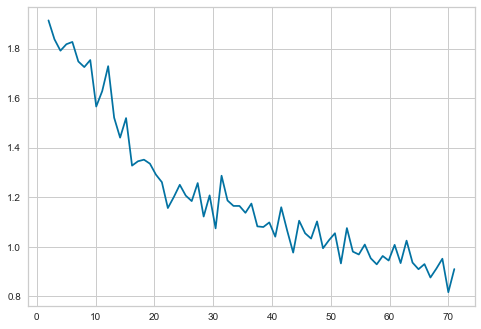

In [113]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledA,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)
#smooth out and take ebery 5 to 10 points 
#find elbow 
#find average length of frameworks

5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]


TypeError: list indices must be integers or slices, not numpy.float64

<Figure size 360x360 with 0 Axes>

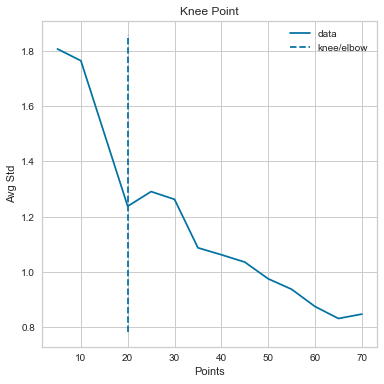

In [27]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledA,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")

print(std_list[knee.knee])

5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]


TypeError: list indices must be integers or slices, not numpy.float64

<Figure size 360x360 with 0 Axes>

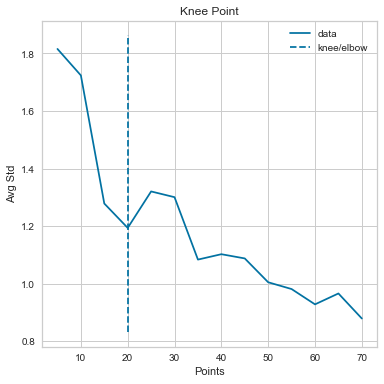

In [28]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledB,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")

print(std_list[knee.knee])

5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]


TypeError: list indices must be integers or slices, not numpy.float64

<Figure size 360x360 with 0 Axes>

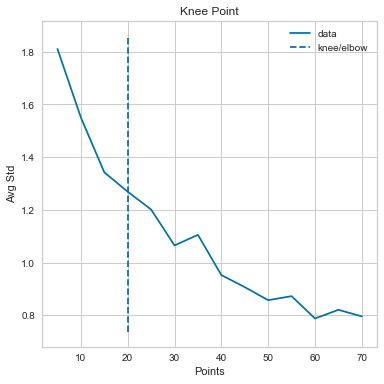

In [29]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledC,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")

print(std_list[knee.knee])

5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]


TypeError: list indices must be integers or slices, not numpy.float64

<Figure size 360x360 with 0 Axes>

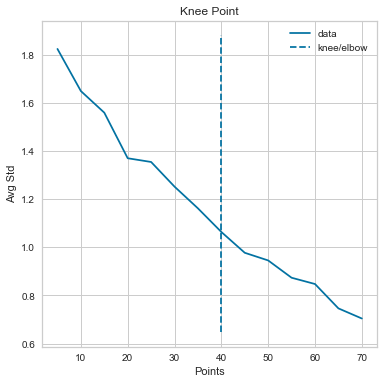

In [30]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledD,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")

print(std_list[knee.knee])
'''i love'''

5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]


Text(0.5, 1.0, 'Goetzke')

<Figure size 360x360 with 0 Axes>

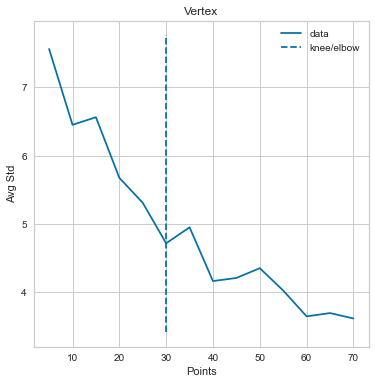

<Figure size 360x360 with 0 Axes>

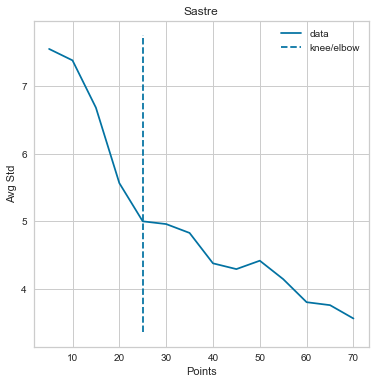

<Figure size 360x360 with 0 Axes>

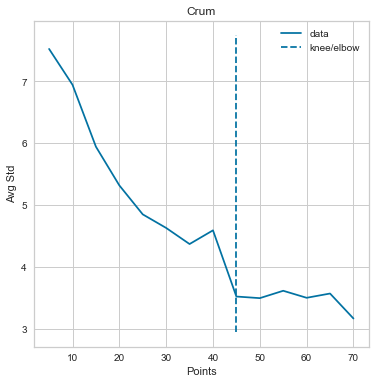

<Figure size 360x360 with 0 Axes>

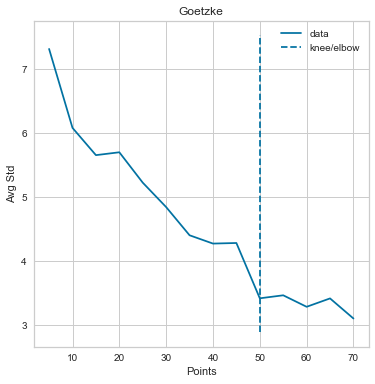

In [31]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledA,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Vertex')

std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledB,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Sastre')

std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledC,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Crum')

std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledD,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Goetzke')





5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]
5
10
15
20
25
30
35
40
45
50
55
60
65
70
14 [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.]


Text(0.5, 1.0, 'Goetzke')

<Figure size 360x360 with 0 Axes>

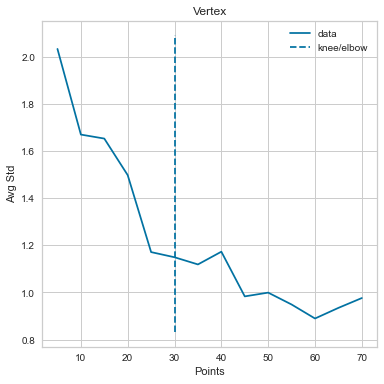

<Figure size 360x360 with 0 Axes>

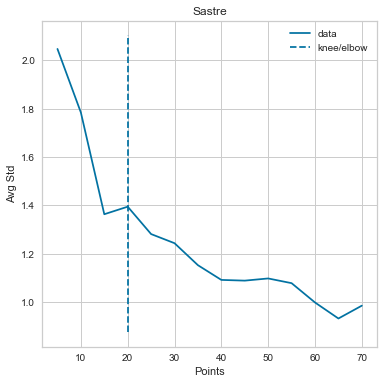

<Figure size 360x360 with 0 Axes>

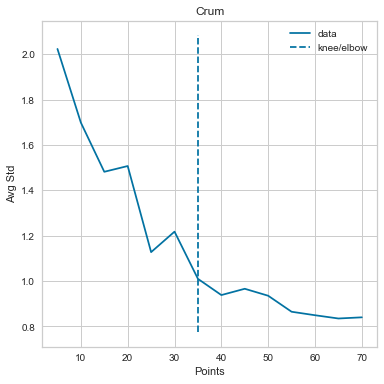

<Figure size 360x360 with 0 Axes>

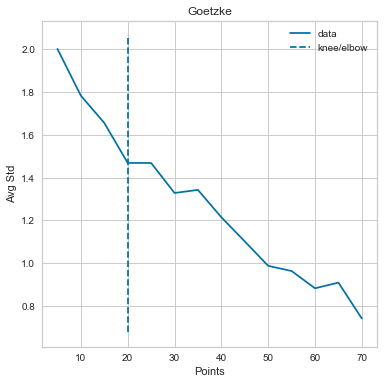

In [32]:
std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledA,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Vertex')

std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledB,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Sastre')

std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledC,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Crum')

std_list = []
x = np.linspace(5,70,14)
for i in range(5,71,5):
    print(i)
    avg, std = properties(scaledD,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
#plt.plot(x,std_list)
print(len(std_list),x)

knee = KneeLocator(x, std_list, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Avg Std")
plt.title('Goetzke')


In [ ]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledB,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

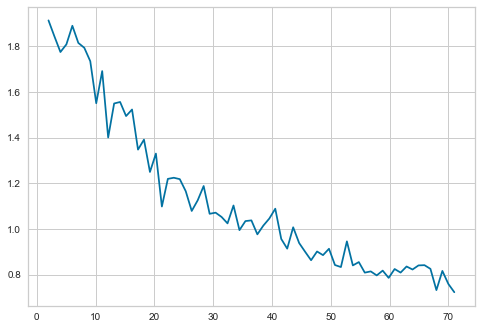

In [117]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledC,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

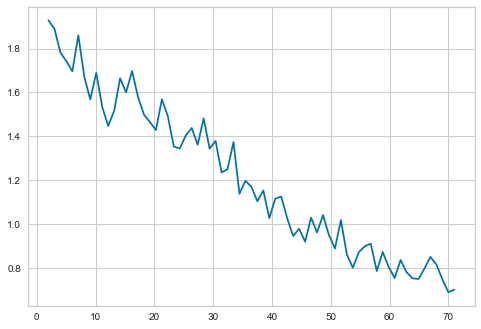

In [118]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledD,density,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

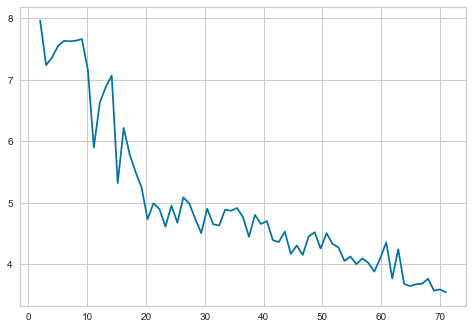

In [114]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledA,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

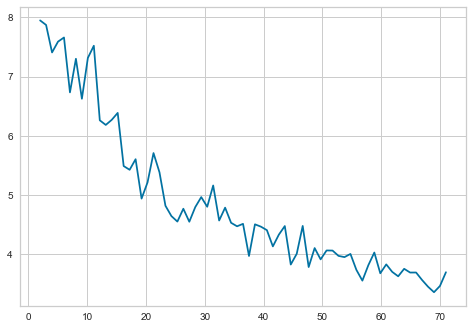

In [119]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledB,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

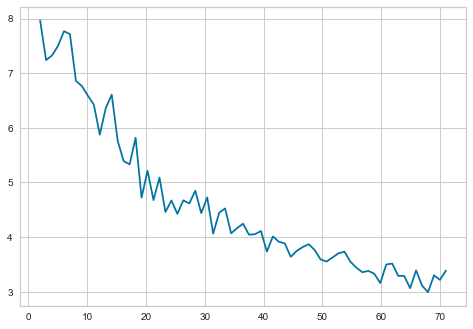

In [120]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledC,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

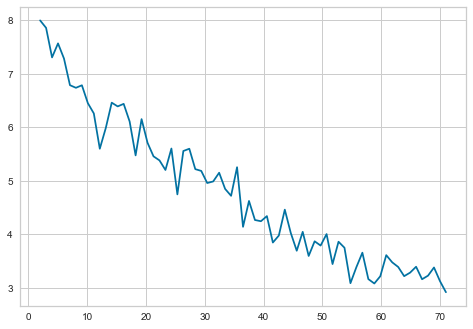

In [121]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledD,accessiblevolume,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

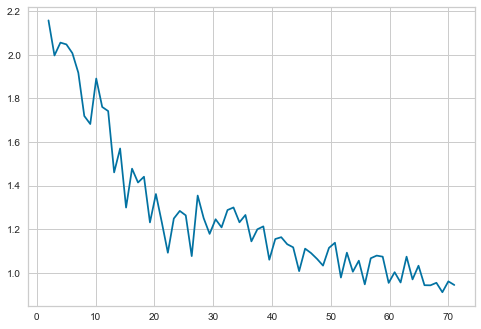

In [115]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledA,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

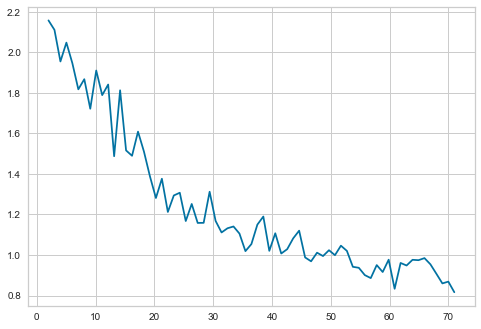

In [122]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledB,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

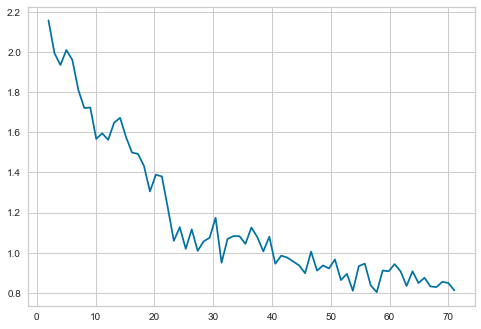

In [123]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledC,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

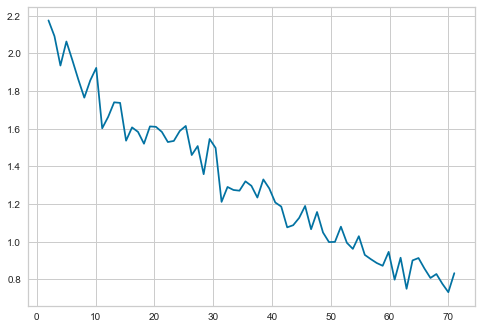

In [124]:
std_list = []
x = np.linspace(2,71,69)
for i in range(2,71):
    avg, std = properties(scaledD,mdiameter,i,vbool=False)
    astd = sum(std)/len(std)
    std_list.append(astd)
plt.plot(x,std_list)

<ErrorbarContainer object of 3 artists>

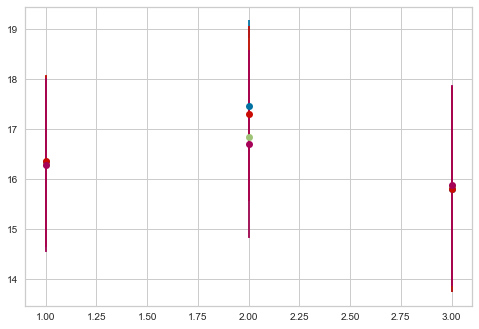

In [139]:
x = np.linspace(1,3,3)

vx, vy = properties(scaledA,density,3,vbool=False)

sx, sy = properties(scaledB,density,3,vbool=False)

cx, cy = properties(scaledC,density,3,vbool=False)

gx, gy = properties(scaledD,density,3,vbool=False)

#plt.plot(x,vx,'o',label = 'Vertex')
#plt.plot(x,sx,'o',label = 'Sastre')
#plt.plot(x,cx,'o',label = 'Crum')
#plt.plot(x,gx,'o',label = 'Goetzke')

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x, vx, yerr=vy, fmt='o',label = 'Vertex')
ax0.errorbar(x, sx, yerr=sy, fmt='o',label = 'Sastre')
ax0.errorbar(x, cx, yerr=cy, fmt='o',label = 'Crum')
ax0.errorbar(x, gx, yerr=gy, fmt='o',label = 'Goetzke')

<ErrorbarContainer object of 3 artists>

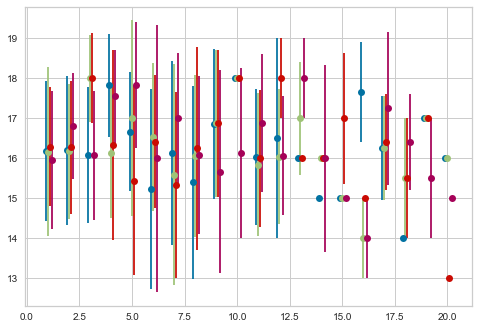

In [22]:
x = np.linspace(1,20,20)

vx, vy = properties(scaledA,density,20,vbool=False)

sx, sy = properties(scaledB,density,20,vbool=False)

cx, cy = properties(scaledC,density,20,vbool=False)

gx, gy = properties(scaledD,density,20,vbool=False)

#plt.plot(x,vx,'o',label = 'Vertex')
#plt.plot(x,sx,'o',label = 'Sastre')
#plt.plot(x,cx,'o',label = 'Crum')
#plt.plot(x,gx,'o',label = 'Goetzke')

fig, (ax0) = plt.subplots(nrows=1, sharex=True)

ax0.errorbar(x-.1, vx, yerr=vy, fmt='o',label = 'Vertex')
ax0.errorbar(x, sx, yerr=sy, fmt='o',label = 'Sastre')
ax0.errorbar(x+.1, cx, yerr=cy, fmt='o',label = 'Crum')
ax0.errorbar(x+.2, gx, yerr=gy, fmt='o',label = 'Goetzke')